# Fatty Liver Disease (FLD) Study

- alcoholic vs non-alcoholic FLD, short: AFLD vs NAFLD


**Outline**

1. Study on liver disease types:
    1. Fibrosis
    1. Steatosis
    2. Inflammation
    
2. Two data sets with 
    1. clinical markers
    2. proteome information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.linear_model as skllm
import sklearn.ensemble as skle

import sklearn.metrics as sklm
import sklearn.model_selection as sklms
from sklearn.model_selection import cross_val_predict

import xgboost
import ipywidgets as widgets
import tqdm

In [2]:
import src.utils as utils

In [3]:
import os
CPUS = os.cpu_count()
RANDOMSTATE = 29

FOLDER_DATA_RAW = 'data/raw'
DATAFOLDER = 'data/processed'
TABLEFOLDER = 'tables'
RESULT_FOLDER = 'results'

# Explore datasets

Diagnostic comparators (existing best-in-class) biomarkers
- Fibrosis markers: transient elastography, 2-dimensional shear wave elastography, ELF test, FibroTest, FIB4 score, APRI score, Forns score, ProC3
- Inflammation markers: M30=caspase-cleaved cytokeratin-18 fragments, M65=total CK18, AST:ALT ratio, ProC3
- Steatosis: Controlled attenuation parameter

In [4]:
pd.set_option('max_columns', 9)

files = [file for file in os.listdir(DATAFOLDER) if '.csv' in file]
w_data = widgets.Dropdown(options=files, index=5)

def show_data(file):
    filename = os.path.join(DATAFOLDER, file)
    global data # only here to show-case data for report
    try:
        data = pd.read_csv(filename, index_col='Sample ID')
    except:
        data = pd.read_csv(filename)
    display(data.head())
out = widgets.interactive_output(show_data, controls={'file':w_data})

widgets.VBox([w_data, out])

In [5]:
# # Possible Alternative for DropDown 
# from src.widgets import multi_checkbox_widget

# descriptions=data.columns
# w_cols = multi_checkbox_widget(descriptions)
# w_cols

In [6]:
w_cols = widgets.SelectMultiple(options=list(data.columns))

def show_selected_proteins(columns):
    if len(columns)> 0:
        display(data[list(w_cols.value)])
        print(data[list(w_cols.value)].describe())
    else:
        print('Select proteins')

out_sel = widgets.interactive_output(show_selected_proteins, {'columns': w_cols})
widgets.VBox([w_cols, out_sel])

## Proteomics data

### Load Complete proteomics data

Full preprocessing pipeline

In [7]:
FOLDER_DATA_RAW = 'data/raw'
annotation_file = pd.read_csv(os.path.join(FOLDER_DATA_RAW, 'Experiment annotation file.csv'), index_col = [0])
annotation_file_plasma = annotation_file[annotation_file['Sample type'] == 'Plasma']
annotation_file_plasma.index = pd.Index(annotation_file_plasma.index, dtype=int)
display(annotation_file_plasma.head())
annotation_file_plasma.describe()

,File name,Sample ID,Groups,Species,Group2,Sample type
0,[1] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A1,QC,Human,QC,Plasma
1,[2] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A2,HP,Human,HP,Plasma
2,[3] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A3,HP,Human,HP,Plasma
3,[4] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A4,ALD,Human,ALD,Plasma
4,[5] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Pla...,Plate1_A5,ALD,Human,ALD,Plasma


,File name,Sample ID,Groups,Species,Group2,Sample type
count,603,603,603,603,603,603
unique,603,603,4,1,3,1
top,[271] 20190525_QE10_Evosep1_P0000005_LiNi_SA_P...,Plate5_G12,ALD,Human,ALD,Plasma
freq,1,1,355,603,459,603


In [8]:
annotation_file_plasma["Sample ID"]

0       Plate1_A1
1       Plate1_A2
2       Plate1_A3
3       Plate1_A4
4       Plate1_A5
          ...    
598    Plate7_C10
599    Plate7_C11
600    Plate7_C12
601     Plate7_D1
602     Plate7_D2
Name: Sample ID, Length: 603, dtype: object

In [9]:
report_plasma = pd.read_csv(os.path.join(FOLDER_DATA_RAW, '20190620_210717_20190620_P0000005_Lili2Klibrary_Report.csv'), na_values='Filtered' )
report_plasma.rename({'PG.Genes': 'Gene names', 'PG.ProteinAccessions': 'Protein ID'}, inplace= True, axis=1)
report_plasma.head()
columns_ = ['Protein ID', 'Gene names']
ids_ = report_plasma[columns_].apply(lambda series_: series_.str.split(';'))

In [10]:
ids_ # ToDo:  create mapping object (see if proteins are unique -> get function from other project)

,Protein ID,Gene names
0,[A0A024R6I7],[SERPINA1]
1,[A0A075B6I0],[IGLV8-61]
2,[A0A075B6J9],[IGLV2-18]
3,"[A0A075B6R9, A0A0C4DH68]","[IGKV2D-24, IGKV2-24]"
4,"[A0A075B6S2, A2NJV5]","[IGKV2D-29, IGKV2-29]"
...,...,...
519,[Q9Y5Y7],[LYVE1]
520,[Q9Y646],[CPQ]
521,[Q9Y6R7],[FCGBP]
522,[Q9Y6Z7],[COLEC10]


In [11]:
def length_(x):
    try:
        return len(x)
    except:
        return 0
    
count_groups_proteins = ids_.apply(lambda series_: series_.apply(length_))
def compare_count(df, column_1, column_2):
    """Takes pandas.DataFrame and two of it's columns. Returns counts of 
    two columns for values of the two columns."""
    return df[column_1].value_counts().sort_index().to_frame().merge(
        df[column_2].value_counts().sort_index(),
        left_index=True, right_index=True, how='outer')
       
# count_groups_proteins = count_groups_proteins[columns_[0]].value_counts().sort_index().to_frame().merge(
#         count_groups_proteins[columns_[1]].value_counts().sort_index(),
#         left_index=True, right_index=True, how='outer')
compare_count(count_groups_proteins, *columns_)

,Protein ID,Gene names
0,NaN,2.0
1,318.0,499.0
2,121.0,11.0
3,44.0,3.0
4,20.0,2.0
5,7.0,3.0
6,6.0,1.0
7,1.0,NaN
8,1.0,NaN
10,1.0,NaN


In [12]:
NP_LOG_FCT = np.log2

def log2(row: pd.Series):
    """Apply log Transformation to values."""
    return NP_LOG_FCT(row.where(row != 0.0))

RANDOM_SEED = 123

IMPUTATION_MEAN_SHIFT    = 1.8
IMPUTATION_STD_SHRINKAGE = 0.3

def imputation_normal_distribution(log_intensities: pd.Series, mean_shift=IMPUTATION_MEAN_SHIFT, std_shrinkage=IMPUTATION_STD_SHRINKAGE):
    """Impute missing log-transformed intensity values of DDA run.

    Parameters
    ----------
    log_intensities: pd.Series
        Series of normally distributed values. Here usually log-transformed
        protein intensities.
    mean_shift: integer, float
        Shift the mean of the log_intensities by factors of their standard
        deviation to the negative.
    std_shrinkage: float
        Value greater than zero by which to shrink (or inflate) the 
        standard deviation of the log_intensities.
    """
    np.random.seed(RANDOM_SEED)
    if not isinstance(log_intensities, pd.Series):
        try:
            log_intensities.Series(log_intensities)
            logger.warning("Series created of Iterable.")
        except:
            raise ValueError(
                "Plese provided data which is a pandas.Series or an Iterable")
    if mean_shift < 0:
        raise ValueError(
            "Please specify a positive float as the std.-dev. is non-negative.")
    if std_shrinkage <= 0:
        raise ValueError(
            "Please specify a positive float as shrinkage factor for std.-dev.")
    if std_shrinkage >= 1:
        logger.warning("Standard Deviation will increase for imputed values.")

    mean = log_intensities.mean()
    std = log_intensities.std()

    mean_shifted = mean - (std * mean_shift)
    std_shrinked = std * std_shrinkage

    return log_intensities.where(log_intensities.notna(),
                                 np.random.normal(mean_shifted, std_shrinked))

In [13]:
# Report_plasma = pd.read_csv('raw/proteomics/plasma/20190620_210717_20190620_P0000005_Lili2Klibrary_Report.csv')
experimental_columns = annotation_file_plasma['Sample ID']
report_plasma[columns_] = report_plasma[columns_].apply(lambda series_: series_.str.split(';').str[0])

In [14]:
report_plasma.describe()

,[1] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A1.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[2] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A2.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[3] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A3.htrms.PG.NrOfStrippedSequencesUsedForQuantification,[4] 20190514_QE10_Evosep1_P0000005_LiNi_SA_Plate1_A4.htrms.PG.NrOfStrippedSequencesUsedForQuantification,...,[600] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_C11.htrms.PG.Quantity,[601] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_C12.htrms.PG.Quantity,[602] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_D1.htrms.PG.Quantity,[603] 20190618_QE10_Evosep1_P0000005_LiNi_SA_Plate7_D2.htrms.PG.Quantity
count,361.000000,327.000000,317.000000,340.000000,...,3.640000e+02,3.200000e+02,3.130000e+02,3.220000e+02
mean,2.124654,2.171254,2.192429,2.191176,...,3.939520e+06,4.541551e+06,4.727407e+06,4.267386e+06
std,0.933022,0.927444,0.912747,0.903245,...,4.108969e+07,4.513567e+07,4.711617e+07,4.104998e+07
min,1.000000,1.000000,1.000000,1.000000,...,1.908130e+02,5.826772e+02,7.995712e+02,2.039593e+02
25%,1.000000,1.000000,1.000000,1.000000,...,8.566062e+03,1.047221e+04,1.268499e+04,1.084710e+04
50%,3.000000,3.000000,3.000000,3.000000,...,4.154654e+04,6.404788e+04,6.787159e+04,6.053365e+04
75%,3.000000,3.000000,3.000000,3.000000,...,4.774295e+05,6.070775e+05,7.744870e+05,6.438288e+05
max,3.000000,3.000000,3.000000,3.000000,...,7.727070e+08,7.973126e+08,8.239611e+08,7.269720e+08


In [15]:
map_filenames_ids = dict(zip(annotation_file['File name'], annotation_file['Sample ID']))

Remove some measurements which are not intensities, but ... ?

In [16]:
data_plasma_raw = report_plasma.copy()
data_plasma_raw.drop(data_plasma_raw.filter(regex='StrippedSequences').columns, axis=1, inplace = True)

- rename column names to sample ID from annotation file
- set index to proteins

In [17]:
data_plasma_raw = data_plasma_raw.rename(mapper = map_filenames_ids, axis=1)
IDmapping_UniprotID_to_Genename = dict(zip(data_plasma_raw['Protein ID'], data_plasma_raw['Gene names']))
data_plasma_raw = data_plasma_raw.set_index('Protein ID').drop('Gene names', axis = 1)
data_plasma_raw.shape

(524, 603)

In [18]:
mask = data_plasma_raw.notna().sum(axis=1) > 603 * 0.6
mask.sum()

304

Filter at protein level for 60% data completeness across all runs

In [19]:
DATA_COMPLETENESS = 0.6
data_plasma_filtered = data_plasma_raw.dropna(axis=0, thresh = data_plasma_raw.shape[1] * DATA_COMPLETENESS)
data_plasma_filtered

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,6.200196e+05,2.331762e+06,2.586371e+04,5.338210e+03,...,4.113509e+03,2.998578e+03,NaN,1.988878e+06
A0A075B6I0,6.295342e+05,8.450854e+05,2.373902e+05,3.643702e+05,...,4.722763e+05,3.496285e+05,3.066827e+05,3.786927e+05
A0A075B6J9,1.681740e+05,1.627395e+05,1.855113e+05,9.158264e+04,...,3.596762e+04,1.363557e+05,1.330743e+05,6.273911e+05
A0A075B6R9,3.775132e+05,5.170737e+05,3.844323e+05,2.721132e+05,...,9.784640e+04,3.716600e+05,1.769536e+05,1.536745e+05
A0A075B6S2,3.906652e+06,3.630775e+06,2.398308e+06,3.057330e+06,...,3.905379e+06,4.987740e+06,5.406188e+06,6.198768e+06
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,4.865861e+03,5.296482e+03,7.799022e+03,3.205460e+03,...,6.996103e+03,2.350951e+03,5.607277e+03,4.150832e+03
Q9Y5Y7,1.992382e+04,2.703403e+04,2.709656e+04,1.464827e+04,...,1.341996e+04,9.023039e+03,9.431375e+03,1.067457e+04
Q9Y6R7,1.148318e+04,1.718446e+04,3.122548e+04,2.017434e+04,...,8.169301e+03,8.141091e+03,NaN,7.094049e+03


Check how many the plates which will be discarded have:

In [20]:
mask_filtered_out = data_plasma_filtered.notna().sum() < 200
data_plasma_filtered.loc[:, list(mask_filtered_out)].describe().loc['count'].astype(int).sort_values()

Plate1_E1     80
Plate7_B6    114
Plate4_E3    117
Plate3_H2    119
Name: count, dtype: int32

In [21]:
data_plasma_raw.loc[:, mask_filtered_out].describe().loc['count'].astype(int).sort_values()

Plate1_E1     85
Plate4_E3    121
Plate3_H2    127
Plate7_B6    169
Name: count, dtype: int32

> Cutoff of 118 is next one where another sample would be discarded.

Filter at sample level for a total number of quantified protein groups above 200 (of 290).

In [22]:
MIN_N_PROTEIN_GROUPS = 200
print(f"Min No. of Protein-Groups in single sample: {MIN_N_PROTEIN_GROUPS}, i.e. a fraction of {MIN_N_PROTEIN_GROUPS/len(data_plasma_filtered)}")

Min No. of Protein-Groups in single sample: 200, i.e. a fraction of 0.6578947368421053


In [23]:
data_plasma_filtered = data_plasma_filtered.dropna(axis=1, thresh = MIN_N_PROTEIN_GROUPS)
data_plasma_filtered

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,6.200196e+05,2.331762e+06,2.586371e+04,5.338210e+03,...,4.113509e+03,2.998578e+03,NaN,1.988878e+06
A0A075B6I0,6.295342e+05,8.450854e+05,2.373902e+05,3.643702e+05,...,4.722763e+05,3.496285e+05,3.066827e+05,3.786927e+05
A0A075B6J9,1.681740e+05,1.627395e+05,1.855113e+05,9.158264e+04,...,3.596762e+04,1.363557e+05,1.330743e+05,6.273911e+05
A0A075B6R9,3.775132e+05,5.170737e+05,3.844323e+05,2.721132e+05,...,9.784640e+04,3.716600e+05,1.769536e+05,1.536745e+05
A0A075B6S2,3.906652e+06,3.630775e+06,2.398308e+06,3.057330e+06,...,3.905379e+06,4.987740e+06,5.406188e+06,6.198768e+06
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,4.865861e+03,5.296482e+03,7.799022e+03,3.205460e+03,...,6.996103e+03,2.350951e+03,5.607277e+03,4.150832e+03
Q9Y5Y7,1.992382e+04,2.703403e+04,2.709656e+04,1.464827e+04,...,1.341996e+04,9.023039e+03,9.431375e+03,1.067457e+04
Q9Y6R7,1.148318e+04,1.718446e+04,3.122548e+04,2.017434e+04,...,8.169301e+03,8.141091e+03,NaN,7.094049e+03


In [24]:
assert (data_plasma_filtered.dtypes != float).sum() == 0

In [25]:
# data_plasma_filtered = convert_to_numeric(data_plasma_filtered)
# data_plasma_filtered_log = np.log2(data_plasma_filtered)
data_plasma_filtered_log = data_plasma_filtered.apply(log2)
data_plasma_filtered_log

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,19.241954,21.152989,14.658642,12.382140,...,12.006154,11.550063,NaN,20.923524
A0A075B6I0,19.263925,19.688738,17.856901,18.475045,...,18.849272,18.415463,18.226387,18.530668
A0A075B6J9,17.359595,17.312205,17.501147,16.482787,...,15.134411,17.057015,17.021873,19.259006
A0A075B6R9,18.526168,18.980010,18.552370,18.053848,...,16.578231,18.503624,17.433012,17.229518
A0A075B6S2,21.897501,21.791846,21.193585,21.543841,...,21.897031,22.249955,22.366180,22.563550
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,12.248479,12.370819,12.929078,11.646316,...,12.772336,11.199029,12.453085,12.019185
Q9Y5Y7,14.282206,14.722489,14.725822,13.838443,...,13.712093,13.139398,13.203252,13.381890
Q9Y6R7,13.487235,14.068817,14.930436,14.300234,...,12.995997,12.991006,NaN,12.792394


##### Imputation

- imputation is done before coefficient of variation (CV)
- is this sensible?

In [26]:
SCALE_DATA = False
if SCALE_DATA:
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()

    data_plasma_filtered_log_imputed_np = scaler.fit_transform(data_plasma_filtered_log.values)
    data_plasma_filtered_log_imputed = data_plasma_filtered_log.copy()
    data_plasma_filtered_log_imputed.loc[:,:] = np.nan_to_num(data_plasma_filtered_log_imputed_np)
else:
    data_plasma_filtered_log_imputed = data_plasma_filtered_log.apply(imputation_normal_distribution)
    assert data_plasma_filtered_log_imputed.loc['Q9Y6Z7', 'Plate1_A2'] - 9.770809 < 0.0001, 'Imputed value changed in comparison to previous run'

In [27]:
# ToDo: Look at distribution of imputed values vs non-imputed values by protein.

In [28]:
from pathlib import Path
file = Path('data/processed/plasma_processed.csv')
file.parent.mkdir(parents=True, exist_ok=True)

In [29]:
import logging
try:
    data_plasma_filtered_log_imputed.to_csv(file.absolute())
except PermissionError as e:
    logging.warning(f"No write permission to directory: {e}")

ToDo: Standardize before imputing ?

In [30]:
data_plasma_filtered

,Plate1_A1,Plate1_A2,Plate1_A3,Plate1_A4,...,Plate7_C11,Plate7_C12,Plate7_D1,Plate7_D2
Protein ID,,,,,,,,,
A0A024R6I7,6.200196e+05,2.331762e+06,2.586371e+04,5.338210e+03,...,4.113509e+03,2.998578e+03,NaN,1.988878e+06
A0A075B6I0,6.295342e+05,8.450854e+05,2.373902e+05,3.643702e+05,...,4.722763e+05,3.496285e+05,3.066827e+05,3.786927e+05
A0A075B6J9,1.681740e+05,1.627395e+05,1.855113e+05,9.158264e+04,...,3.596762e+04,1.363557e+05,1.330743e+05,6.273911e+05
A0A075B6R9,3.775132e+05,5.170737e+05,3.844323e+05,2.721132e+05,...,9.784640e+04,3.716600e+05,1.769536e+05,1.536745e+05
A0A075B6S2,3.906652e+06,3.630775e+06,2.398308e+06,3.057330e+06,...,3.905379e+06,4.987740e+06,5.406188e+06,6.198768e+06
...,...,...,...,...,...,...,...,...,...
Q9Y5C1,4.865861e+03,5.296482e+03,7.799022e+03,3.205460e+03,...,6.996103e+03,2.350951e+03,5.607277e+03,4.150832e+03
Q9Y5Y7,1.992382e+04,2.703403e+04,2.709656e+04,1.464827e+04,...,1.341996e+04,9.023039e+03,9.431375e+03,1.067457e+04
Q9Y6R7,1.148318e+04,1.718446e+04,3.122548e+04,2.017434e+04,...,8.169301e+03,8.141091e+03,NaN,7.094049e+03


In [31]:
qc_plasma = annotation_file_plasma[annotation_file_plasma['Group2'] == 'QC']['Sample ID']
df_qc = data_plasma_filtered.copy()[qc_plasma]
coef_of_variation = lambda x: np.std(x) / np.mean(x)
proteins_cv = df_qc.apply(coef_of_variation, axis = 1)

In [32]:
CV_COEFFICIENT = 0.3
cv_selected = proteins_cv < CV_COEFFICIENT
print(f"Selected proteins # {cv_selected.sum()} of a total of # {len(cv_selected)}!")

Selected proteins # 219 of a total of # 304!


In [33]:
df_qc = df_qc.assign(cv = proteins_cv)
qc_30 = df_qc[cv_selected].index

df = data_plasma_filtered_log_imputed.copy()
df = df.rename_axis('Sample ID', axis=1).T
# filter proteins for CV < 30% of the inter-day/plate quality assessment 
df_30 = df[qc_30]
data_proteomics = df_30

In [34]:
PROTEOM  = 'data_ml_proteomics_cleaned.csv'

data_proteomics.to_csv(os.path.join(DATAFOLDER, PROTEOM))
data_proteomics

Protein ID,A0A024R6I7,A0A075B6I0,A0A075B6J9,A0A075B6R9,...,Q9Y5C1,Q9Y5Y7,Q9Y6Z7,V9GYM3
Sample ID,,,,,,,,,
Plate1_A1,19.241954,19.263925,17.359595,18.526168,...,12.248479,14.282206,13.201056,24.410428
Plate1_A2,21.152989,19.688738,17.312205,18.980010,...,12.370819,14.722489,9.503856,24.562142
Plate1_A3,14.658642,17.856901,17.501147,18.552370,...,12.929078,14.725822,13.830207,24.776309
Plate1_A4,12.382140,18.475045,16.482787,18.053848,...,11.646316,13.838443,9.544955,24.402429
Plate1_A5,11.449945,18.653026,15.673456,17.827835,...,12.144853,14.278546,9.453771,24.842651
...,...,...,...,...,...,...,...,...,...
Plate7_C10,13.992607,17.711436,17.170434,17.593782,...,12.622469,13.450106,14.258025,24.261786
Plate7_C11,12.006154,18.849272,15.134411,16.578231,...,12.772336,13.712093,12.411197,23.681672
Plate7_C12,11.550063,18.415463,17.057015,18.503624,...,11.199029,13.139398,9.166826,24.232875


In [35]:
intensities_below_8 = data_proteomics[data_proteomics < 8].dropna(how='all').dropna(how='all', axis=1)
intensities_below_8

Protein ID,E9PEP6,P20742,P23470,P29508,P32119,P34096,Q86UD1
Sample ID,,,,,,,
Plate2_G11,7.943981,NaN,NaN,NaN,NaN,NaN,NaN
Plate3_E12,NaN,NaN,NaN,NaN,6.6718,NaN,NaN
Plate5_C4,NaN,NaN,NaN,NaN,NaN,0.0,NaN
Plate5_C9,NaN,NaN,NaN,NaN,NaN,NaN,7.997238
Plate5_H7,NaN,NaN,0.0,NaN,NaN,NaN,NaN
Plate6_C4,NaN,NaN,NaN,6.994776,NaN,NaN,NaN
Plate7_A9,NaN,7.516699,NaN,NaN,NaN,NaN,NaN


In [36]:
data_proteomics.loc[intensities_below_8.index, intensities_below_8.columns]

Protein ID,E9PEP6,P20742,P23470,P29508,P32119,P34096,Q86UD1
Sample ID,,,,,,,
Plate2_G11,7.943981,9.218392,12.627170,9.218392,12.689431,12.141700,14.219719
Plate3_E12,8.930690,18.398998,12.498869,8.930690,6.671800,11.506953,13.143613
Plate5_C4,8.748182,18.163920,12.993120,21.373968,13.405002,0.000000,12.974315
Plate5_C9,9.181562,15.631481,12.443023,21.339160,14.487712,11.500707,7.997238
Plate5_H7,8.675619,14.654771,0.000000,21.481735,13.630898,11.832212,13.037990
Plate6_C4,13.914996,12.411481,13.779482,6.994776,12.838674,12.912724,9.326952
Plate7_A9,12.679690,7.516699,13.676987,21.267399,15.309246,9.170928,9.170928


Data proteomics is the summary of the following processing steps:

1. protein is selected if shared betw. 60% of samples
2. sample is selected if it has at least 200 proteins
3. log-transform
4. imputation (imputation done per protein between runs)
5. selection using CV < 0.3

> Maybe create an automated report of the cutoffs.

In [37]:
summary_protein_preprocessing = [("Proportion protein has to be shared between samples" , DATA_COMPLETENESS),
                                 ("Minimum number of protein in single sample", MIN_N_PROTEIN_GROUPS),
                                 ("Maximum coefficient of variation (CV) for protein intensities", CV_COEFFICIENT),
                                 ("Logarithm employed for transformation", NP_LOG_FCT),
                                 ("Imputation: Mean-Shift", IMPUTATION_MEAN_SHIFT), 
                                 ("Imputation: Std-Dev. shrinkage", IMPUTATION_STD_SHRINKAGE)
                                ]

for descr, value in summary_protein_preprocessing:
    print('{}: {}'.format(descr, value))

Proportion protein has to be shared between samples: 0.6
Minimum number of protein in single sample: 200
Maximum coefficient of variation (CV) for protein intensities: 0.3
Logarithm employed for transformation: <ufunc 'log2'>
Imputation: Mean-Shift: 1.8
Imputation: Std-Dev. shrinkage: 0.3


### Load Protein GeneID Mapping

- UniProtID to Gene name mapping
- the assigned protein groups are mapped to mainly one, sometimes two genes -> Global Identifiers?!


In [38]:
key_ProteinID = pd.read_csv(os.path.join(DATAFOLDER, 'ID_matching_key.csv'), 
                            index_col="Protein ID").drop("Unnamed: 0", axis=1)
key_ProteinID.head()

,Gene names
Protein ID,
A0A024R6I7,SERPINA1
A0A075B6I0,IGLV8-61
A0A075B6J9,IGLV2-18
A0A075B6R9,IGKV2D-24
A0A075B6S2,IGKV2D-29


In [39]:
key_ProteinID.loc['P35858']

Gene names    IGFALS
Name: P35858, dtype: object

## Clinical data
### Load Complete clinical data

In [40]:
CLINICAL = 'df_cli_164.csv'
COL_ID = 'Sample ID'

In [41]:
CLINICAL = 'df_cli_164.csv'
COL_ID = 'Sample ID'

f_data_clinic = os.path.join(DATAFOLDER, CLINICAL)
data_cli = pd.read_csv(f_data_clinic, index_col=COL_ID)
data_cli = data_cli[data_cli['kleiner']!=0.5]
data_cli.head()

,age,kleiner,cpa,nas,...,group,group2,type,fibrosis_class
Sample ID,,,,,,,,,
Plate6_G11,64,3.0,9.216155,0.0,...,ALD,ALD,Compensated advanced fibrosis,F3-4
Plate1_F7,74,2.0,4.874057,3.0,...,ALD,ALD,Steatohepatitis,F2
Plate6_D2,71,1.0,3.199472,3.0,...,ALD,ALD,Steatohepatitis,F0-1
Plate6_C5,53,2.0,4.762666,5.0,...,ALD,ALD,Steatohepatitis,F2
Plate4_F8,63,4.0,13.702832,4.0,...,ALD,ALD,Compensated advanced fibrosis,F3-4


In [42]:
w_cols_cli = widgets.SelectMultiple(options=list(data_cli.columns))

def show_selected_markers(columns):
    if len(columns)> 0:
        display(data_cli[list(w_cols_cli.value)])
        display(data_cli[list(w_cols_cli.value)].describe())
    else:
        print('Select clinical markers')

out_cli = widgets.interactive_output(show_selected_markers, {'columns': w_cols_cli})
widgets.VBox([w_cols_cli, out_cli])

### Selected Clinical markers

Diagnostic comparators (existing best-in-class) biomarkers
- state-of-the-art (**SOTA**) Fibrosis markers: 
    - `te`: transient elastography (sona liver scan)
    - `swe`: 2-dimensional shear wave elastography
    - `elf`: ELF test
    - `ft`: FibroTest
    - `fib4`: FIB4 score
    - `apri`: APRI score
    - `forns`: Forns score
    - `p3np`: ProC3
- Inflammation markers:
    - M30=caspase-cleaved cytokeratin-18 fragments
    - M65=total CK18
    - AST:ALT ratio
    - ProC3
- Steatosis: Controlled attenuation parameter

In [43]:
#SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
SOTA_fibrosis = ['elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].count()

,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,
0.0,35,33,36,36,36,35
1.0,120,93,120,121,123,113
2.0,104,76,104,104,103,95
3.0,27,17,26,26,27,22
4.0,63,49,66,66,67,54


In [44]:
pd.set_option('max_columns', 20)
FEATURES_ML = ['nas_steatosis_ordinal', 'nas_inflam', 'kleiner', 
          'fib4', 'elf', 'ft', 'te', 'swe', 'aar','ast',
          'apri','forns','m30', 'm65', 'meld', 'p3np', 'timp1', 'cap' ]
data_cli[FEATURES_ML].head()

,nas_steatosis_ordinal,nas_inflam,kleiner,fib4,elf,ft,te,swe,aar,ast,apri,forns,m30,m65,meld,p3np,timp1,cap
Sample ID,,,,,,,,,,,,,,,,,,
Plate6_G11,0.0,0.0,3.0,1.380000,8.7,0.29,9.3,NaN,1.50,27.0,0.20,4.75,106.672000,293.25601,7.0,4.8,230.6,NaN
Plate1_F7,1.0,2.0,2.0,8.220000,9.8,0.77,NaN,NaN,2.48,57.0,1.18,8.82,161.834000,438.91800,12.0,7.8,318.7,NaN
Plate6_D2,1.0,2.0,1.0,2.220000,9.6,0.34,8.7,13.1,1.73,26.0,0.27,6.65,84.621803,502.39999,8.0,8.8,276.4,NaN
Plate6_C5,2.0,3.0,2.0,32.700001,11.3,0.83,19.1,NaN,3.71,267.0,11.63,11.88,668.940980,1432.85000,10.0,20.9,549.2,NaN
Plate4_F8,0.0,4.0,4.0,1.660000,11.3,0.52,75.0,28.0,1.48,37.0,0.29,5.70,491.866000,857.37500,7.0,22.0,545.6,NaN


In [45]:
data_cli.groupby('group2')[FEATURES_ML].count()

,nas_steatosis_ordinal,nas_inflam,kleiner,fib4,elf,ft,te,swe,aar,ast,apri,forns,m30,m65,meld,p3np,timp1,cap
group2,,,,,,,,,,,,,,,,,,
ALD,352,352,360,353,350,268,342,332,353,354,354,357,268,266,360,320,320,206
HP,0,0,0,0,0,0,136,136,0,119,0,0,0,0,136,0,0,133


In [46]:
SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].median()

,te,swe,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,,,
0.0,4.40,5.750000,8.30,0.10,1.070,0.270,3.775,7.2
1.0,6.00,6.700000,8.80,0.12,1.195,0.270,4.470,7.2
2.0,9.00,9.300000,9.55,0.34,1.655,0.440,5.820,9.9
3.0,21.60,16.900000,10.60,0.63,2.080,0.485,7.020,13.3
4.0,40.75,28.400001,11.80,0.78,4.000,0.860,8.150,22.4


### Selected Demographics

In [47]:
demographics = data_cli[['age', 'bmi', 'gender_num']] # 1 is male
demographics.describe()

,age,bmi,gender_num
count,497.000000,487.000000,497.000000
mean,54.953722,27.194539,0.726358
std,10.433153,5.180561,0.446277
min,19.000000,13.737373,0.000000
25%,48.000000,23.849999,0.000000
50%,56.000000,26.799999,1.000000
75%,62.000000,30.286856,1.000000
max,75.000000,52.099998,1.000000


In [48]:
SELECTED_DEMOGRAPHICS = ['age', 'gender_num']
data_cli[SELECTED_DEMOGRAPHICS].head()

,age,gender_num
Sample ID,,
Plate6_G11,64,1
Plate1_F7,74,1
Plate6_D2,71,1
Plate6_C5,53,1
Plate4_F8,63,1


### Targets

In [49]:
fibrosis_score = data_cli.kleiner
inflamation_score = data_cli.nas_inflam
steatosis_score = data_cli.nas_steatosis_ordinal

In [50]:
TARGETS = ['kleiner', 'nas_steatosis_ordinal', 'nas_inflam']
Y = data_cli[TARGETS]
Y.describe()

,kleiner,nas_steatosis_ordinal,nas_inflam
count,360.000000,352.000000,352.000000
mean,1.902778,0.982955,1.855114
std,1.248506,1.045813,1.467221
min,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,2.000000,1.000000,2.000000
75%,3.000000,2.000000,3.000000
max,4.000000,3.000000,5.000000


In [51]:
def combine_value_counts(X:pd.DataFrame):
    """Pass a selection of columns to combine it's value counts.
    
    This performs no checks. Make sure the scale of the variables
    you pass is comparable.
    """
    _df = pd.DataFrame()
    for col in X.columns:
        _df[col] = X[col].value_counts()
    freq_targets = _df.sort_index()
    return freq_targets

freq_targets = combine_value_counts(Y)
freq_targets.loc['Total',:] = freq_targets.sum()
freq_targets

,kleiner,nas_steatosis_ordinal,nas_inflam
0.0,36.0,156.0,72.0
1.0,124.0,85.0,91.0
2.0,106.0,72.0,82.0
3.0,27.0,39.0,53.0
4.0,67.0,NaN,31.0
Total,360.0,352.0,329.0


Several binary features can be created.

target      | Scale   | unique values              | Binarization                 |  N samples
-----       | --------| ---------------            | -------------------------    |  ---------
fibrosis    | five    | F0, F1, F2, F3, F4         | (F0,F1) vs (F2, F3, F4)      |
fibrosis    | five    | F0, F1, F2, F3, F4         | (F0,F1,F2) vs (F3, F4)       | 
steatosis   | five    | S0, S1, S2, S3             | (S0) vs (S1, S2, S3)         | 
inflamation | seven   | I0, I1, I2, I3, I4, I5, I6 | (I0, I1) vs (I2, I3, I4, I5) |


Variable naming: `<target>_greater-equal_<value>`

In [52]:
def create_dichotome(series: pd.Series, cutoff_ge):
    """Define a dichtome (binary) variable from a continous feature."""
    return (series.dropna() >= cutoff_ge).astype(int)

In [53]:
kleiner_ge_2 = create_dichotome(Y['kleiner'], 2)
kleiner_ge_2.value_counts(dropna=False, sort=False)

0    160
1    200
Name: kleiner, dtype: int64

In [54]:
kleiner_ge_3 = create_dichotome(Y['kleiner'], 3)
kleiner_ge_3.value_counts(dropna=False, sort=False) # more imbalanced -> cutoff adaption might be important

0    266
1     94
Name: kleiner, dtype: int64

In [55]:
steatosis_ge_1 = create_dichotome(Y['nas_steatosis_ordinal'], 1)
steatosis_ge_1.value_counts(dropna=False, sort=False)

0    156
1    196
Name: nas_steatosis_ordinal, dtype: int64

In [56]:
inflamation_ge_2 = create_dichotome(Y['nas_inflam'], 2)
inflamation_ge_2.value_counts(dropna=False, sort=False)

0    163
1    189
Name: nas_inflam, dtype: int64

In [57]:
#ToDo: Create overview-table

### Clinical Cutoffs for targets

Cutoff for binary grouping of targets

target      | Scale   | unique values                | N samples
----------- | ------- | --------------------------   | -------
fibrosis    | five    | F0, F1, F2, F3, F4           | 
steatosis   | five    | S0, S1, S2, S3 (, S4)        | 
inflamation | seven   | I0, I1, I2, I3, I4, I5(, I6) | 


In [58]:
file_cutoff_clinic = "data/raw/clinical_marker_test_cut-offs.xlsx"
cutoffs_clinic = pd.read_excel(file_cutoff_clinic, sheet_name="cutoffs", index_col='marker')
cutoffs_clinic

,F2,F3,INFL2,steatosis
marker,,,,
te,7.00,15.00,NaN,NaN
swe,8.60,16.40,NaN,NaN
elf,7.70,10.50,NaN,NaN
ft,0.48,0.58,NaN,NaN
fib4,1.45,3.25,NaN,NaN
apri,0.50,1.00,NaN,NaN
forns,NaN,6.80,NaN,NaN
p3np,NaN,NaN,NaN,NaN
m30,NaN,NaN,NaN,NaN


In [59]:
markers_to_drop = []
for marker in cutoffs_clinic.index:
    if marker not in data_cli.columns:
        print(f"{marker}: Missing in clinics data.")
        markers_to_drop.append(marker)

proc3: Missing in clinics data.


`proc3` is not in data_clinic. drop this from the list of cutoffs! (Cutoff can be learned later)

In [60]:
if markers_to_drop:
    cutoffs_clinic.drop(labels=markers_to_drop, inplace=True)
cutoffs_clinic

,F2,F3,INFL2,steatosis
marker,,,,
te,7.00,15.00,NaN,NaN
swe,8.60,16.40,NaN,NaN
elf,7.70,10.50,NaN,NaN
ft,0.48,0.58,NaN,NaN
fib4,1.45,3.25,NaN,NaN
apri,0.50,1.00,NaN,NaN
forns,NaN,6.80,NaN,NaN
p3np,NaN,NaN,NaN,NaN
m30,NaN,NaN,NaN,NaN


Renaming Columns to desired endpoint name

In [61]:
cutoffs_clinic.columns = ['F2', 'F3', 'I2', 'S1']
cutoffs_clinic

,F2,F3,I2,S1
marker,,,,
te,7.00,15.00,NaN,NaN
swe,8.60,16.40,NaN,NaN
elf,7.70,10.50,NaN,NaN
ft,0.48,0.58,NaN,NaN
fib4,1.45,3.25,NaN,NaN
apri,0.50,1.00,NaN,NaN
forns,NaN,6.80,NaN,NaN
p3np,NaN,NaN,NaN,NaN
m30,NaN,NaN,NaN,NaN


Extract certain cutoff for binary targets defined by column name:

In [62]:
cutoffs_clinic['F2'].dropna().to_dict()

{'te': 7.0, 'swe': 8.6, 'elf': 7.7, 'ft': 0.48, 'fib4': 1.45, 'apri': 0.5}

See statistics (e.g. median) of SOTA-markers for clinical fibrosis assessment (represented by categories 0 to 4).

In [63]:
SOTA_fibrosis = ['te', 'swe', 'elf', 'ft', 'fib4', 'apri', 'forns', 'p3np']
data_cli.groupby('kleiner')[SOTA_fibrosis].median()

,te,swe,elf,ft,fib4,apri,forns,p3np
kleiner,,,,,,,,
0.0,4.40,5.750000,8.30,0.10,1.070,0.270,3.775,7.2
1.0,6.00,6.700000,8.80,0.12,1.195,0.270,4.470,7.2
2.0,9.00,9.300000,9.55,0.34,1.655,0.440,5.820,9.9
3.0,21.60,16.900000,10.60,0.63,2.080,0.485,7.020,13.3
4.0,40.75,28.400001,11.80,0.78,4.000,0.860,8.150,22.4


### Handle missing features of clinical data:

Using [`sklearn.impute.simpleImputer`](https://scikit-learn.org/stable/modules/impute.html)'s default `'mean'` strategy. 
Alternatively one could replace missing values with zeros on the standardised data to zero mean and standard deviation of one.

> No imputation of clinical features for now as only single clinical features are used in "univariate" models. Imputation is only sensible if several types of information are combined.

In [64]:
# FEATURES_CLINIC = ['ggt', 'alt', 'ast', 'alk', 'mcv', 'iga', 'igg', 'leu', 'glc']
FEATURES_CLINIC = cutoffs_clinic.index 
data_cli[FEATURES_CLINIC].describe()

,te,swe,elf,ft,fib4,apri,forns,p3np,m30,m65,aar,cap
count,478.000000,468.000000,350.000000,268.000000,353.000000,354.000000,357.000000,320.000000,268.000000,266.000000,353.000000,339.000000
mean,12.909623,11.406838,9.776571,0.347351,2.534051,0.702994,5.631933,13.262187,233.677756,685.670989,1.370283,274.348083
std,16.416191,10.564157,1.508532,0.286632,3.023615,0.990803,2.390873,12.424449,297.008804,850.377366,0.764884,63.001900
min,2.100000,2.100000,6.900000,0.020000,0.270000,0.080000,-1.540000,1.500000,2.126260,82.780701,0.090000,100.000000
25%,4.500000,5.600000,8.700000,0.100000,0.950000,0.240000,4.020000,6.775000,95.456402,271.321750,0.880000,228.000000
50%,6.200000,7.050000,9.400000,0.245000,1.570000,0.405000,5.520000,8.950000,153.139500,440.100005,1.130000,277.000000
75%,10.900000,11.700000,10.700000,0.542500,2.890000,0.770000,7.140000,14.425000,261.165740,835.044495,1.640000,321.000000
max,75.000000,75.599998,14.800000,0.980000,32.700001,11.630000,12.580000,112.500000,3816.990000,10015.900000,4.710000,400.000000


In [65]:
patient_ids_w_target = data_cli[TARGETS].dropna(how='all').index

In [66]:
FEATURES_CLINIC_ALL = list(FEATURES_CLINIC) + SELECTED_DEMOGRAPHICS + TARGETS
data_cli.loc[patient_ids_w_target, FEATURES_CLINIC_ALL].describe().sort_values(by="count", ascending=False, axis=1)

,kleiner,gender_num,age,forns,apri,nas_inflam,aar,nas_steatosis_ordinal,fib4,elf,te,swe,p3np,ft,m30,m65,cap
count,360.000000,360.000000,360.000000,356.000000,353.000000,352.000000,352.000000,352.000000,352.000000,349.000000,341.000000,331.000000,319.000000,268.000000,268.000000,266.000000,205.000000
mean,1.902778,0.763889,55.536111,5.630197,0.703683,1.855114,1.367727,0.982955,2.534773,9.777650,16.260704,13.842900,13.279937,0.347351,233.677756,685.670989,287.107317
std,1.248506,0.425282,10.684319,2.394013,0.992125,1.467221,0.764461,1.045813,3.027889,1.510562,18.386198,11.711420,12.439905,0.286632,297.008804,850.377366,63.930402
min,0.000000,0.000000,19.000000,-1.540000,0.080000,0.000000,0.090000,0.000000,0.270000,6.900000,2.100000,2.100000,1.500000,0.020000,2.126260,82.780701,100.000000
25%,1.000000,1.000000,49.000000,4.012500,0.240000,1.000000,0.877500,0.000000,0.950000,8.700000,5.600000,6.500000,6.750000,0.100000,95.456402,271.321750,245.000000
50%,2.000000,1.000000,56.000000,5.515000,0.400000,2.000000,1.130000,1.000000,1.570000,9.400000,8.700000,8.700000,9.000000,0.245000,153.139500,440.100005,286.000000
75%,3.000000,1.000000,63.000000,7.142500,0.770000,3.000000,1.640000,2.000000,2.892500,10.700000,18.200001,15.850000,14.450000,0.542500,261.165740,835.044495,331.000000
max,4.000000,1.000000,75.000000,12.580000,11.630000,5.000000,4.710000,3.000000,32.700001,14.800000,75.000000,75.599998,112.500000,0.980000,3816.990000,10015.900000,400.000000


In [67]:
def ordered_missing_table(data:pd.DataFrame):
    """Order dataframe by data completeness (first column has most features) 
    and then return an encoding of completeness (1 = available, 0 0 not available)"""
       
    data_missing_table = data.notna().astype(int)
    var_ordered_by_completness = list(data.describe().loc['count'].sort_values(ascending=False).index)
    data_missing_table = data_missing_table.sort_values(by=var_ordered_by_completness)[var_ordered_by_completness]
    return data_missing_table.replace(0, pd.NA).convert_dtypes()


print("Used features: {}".format(", ".join(FEATURES_CLINIC_ALL)))
data_cli_missing_table = ordered_missing_table(data=data_cli.loc[patient_ids_w_target, FEATURES_CLINIC_ALL])
data_cli_missing_table

Used features: te, swe, elf, ft, fib4, apri, forns, p3np, m30, m65, aar, cap, age, gender_num, kleiner, nas_steatosis_ordinal, nas_inflam


,kleiner,gender_num,age,forns,apri,nas_inflam,aar,fib4,nas_steatosis_ordinal,elf,te,swe,p3np,ft,m30,m65,cap
Sample ID,,,,,,,,,,,,,,,,,
Plate1_G11,1,1,1,<NA>,1,1,1,1,1,1,1,1,<NA>,<NA>,<NA>,<NA>,1
Plate5_A2,1,1,1,<NA>,1,1,1,1,1,1,1,1,1,<NA>,<NA>,<NA>,<NA>
Plate3_A10,1,1,1,<NA>,1,1,1,1,1,1,1,1,1,<NA>,<NA>,<NA>,1
Plate1_E10,1,1,1,<NA>,1,1,1,1,1,1,1,1,1,<NA>,<NA>,<NA>,1
Plate7_B6,1,1,1,1,<NA>,1,<NA>,<NA>,1,<NA>,1,1,<NA>,<NA>,<NA>,<NA>,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Plate3_E9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Plate2_B9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Plate1_D8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [68]:
data_cli_missing_table.dropna(how='all', axis=0).dropna(how='all', axis=1)

,kleiner,gender_num,age,forns,apri,nas_inflam,aar,fib4,nas_steatosis_ordinal,elf,te,swe,p3np,ft,m30,m65,cap
Sample ID,,,,,,,,,,,,,,,,,
Plate1_G11,1,1,1,<NA>,1,1,1,1,1,1,1,1,<NA>,<NA>,<NA>,<NA>,1
Plate5_A2,1,1,1,<NA>,1,1,1,1,1,1,1,1,1,<NA>,<NA>,<NA>,<NA>
Plate3_A10,1,1,1,<NA>,1,1,1,1,1,1,1,1,1,<NA>,<NA>,<NA>,1
Plate1_E10,1,1,1,<NA>,1,1,1,1,1,1,1,1,1,<NA>,<NA>,<NA>,1
Plate7_B6,1,1,1,1,<NA>,1,<NA>,<NA>,1,<NA>,1,1,<NA>,<NA>,<NA>,<NA>,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Plate3_E9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Plate2_B9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Plate1_D8,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [69]:
data_cli_missing_table.describe().loc['count'].astype(int)

kleiner                  360
gender_num               360
age                      360
forns                    356
apri                     353
nas_inflam               352
aar                      352
fib4                     352
nas_steatosis_ordinal    352
elf                      349
te                       341
swe                      331
p3np                     319
ft                       268
m30                      268
m65                      266
cap                      205
Name: count, dtype: int32

Compare both available data for proteomics and clinical features

In [70]:
data_proteomics.isna().any(axis=None)

False

In [71]:
in_both = data_proteomics.index.intersection(data_cli_missing_table.index)
data_cli_missing_table.index.difference(in_both)

Index(['Plate4_E3', 'Plate7_B6'], dtype='object', name='Sample ID')

In [72]:
HAS_QUANT_PROT = 'has_prot'
data_cli_missing_table[HAS_QUANT_PROT] = pd.Series(1, index=data_proteomics.index)

In [73]:
data_cli_missing_table.dropna(how='all').describe()

,kleiner,gender_num,age,forns,apri,nas_inflam,aar,fib4,nas_steatosis_ordinal,elf,te,swe,p3np,ft,m30,m65,cap,has_prot
count,360.0,360.0,360.0,356.0,353.0,352.0,352.0,352.0,352.0,349.0,341.0,331.0,319.0,268.0,268.0,266.0,205.0,358.0
mean,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [74]:
data_cli_missing_table = ordered_missing_table(data_cli_missing_table)

In [75]:
data_cli_missing_strings = data_cli_missing_table.fillna(value=0)
data_cli_missing_strings = data_cli_missing_strings.astype(str)
stratifier = data_cli_missing_strings.apply(lambda x : x.str.cat(), axis=1)
display(stratifier.head())
stratifier_tab = stratifier.value_counts()
stratifier_tab

Sample ID
Plate7_B6     111010001101100001
Plate4_E3     111011111101100001
Plate1_G11    111101111111100001
Plate5_A2     111101111111110000
Plate3_A10    111101111111110001
dtype: object

111111111111111111    115
111111111111111110    107
111111111111110001     30
111111111111100001     23
111111111111011110     19
111111111110111110     12
111111111111110000      6
111111111111111001      5
111111111101100001      5
111111111110011110      4
111111111111110111      4
111110001101100001      2
111101111111110001      2
111111110001100001      2
111110001111100001      2
111110001111110001      2
111111111111111101      2
111111110010111110      1
111111001111111111      1
111111110011000001      1
111111111111010001      1
111111111111000001      1
111111110011100001      1
111010001101100001      1
111111110011110001      1
111101111111100001      1
111111111111110110      1
111011111101100001      1
111101111111110000      1
111111111110111111      1
111111110011111110      1
111111111110010000      1
111111110011010001      1
111111111111010000      1
111111111111100000      1
dtype: int64

We will have to get ride of the singletons (unique value only once observed). Possibly the grouping could be extended to the values up to 5.

In [76]:
unique_missing_patterns = list(stratifier_tab.index)

def match_observed(seq1, seq2):
    return sum(pos1 == pos2 for pos1, pos2 in zip(seq1, seq2))

assert match_observed("111111110011100001", "111111110011110010") == 15, "Failed"

In [77]:
stratifier.value_counts().min()

1

In [78]:
def update_stratifier(stratifier_var, threshold=None):
    stratifier_var =stratifier_var.copy()
    stratifier_tab = stratifier_var.value_counts()
    if threshold is None:
        threshold=stratifier_tab.min()
    unique_missing_patterns = list(stratifier_tab.index)
    list_single_missing_patterns = stratifier_tab[stratifier_tab <= threshold].index
    for single_missing_pattern in list_single_missing_patterns:
        print(f"Find match for: {single_missing_pattern}")
        closest = 0
        for i, other_seq in enumerate(unique_missing_patterns):
            if not other_seq in list_single_missing_patterns:
                relatedness = match_observed(single_missing_pattern, other_seq)
                if relatedness > closest:
                    closest = relatedness
                    best = other_seq
        stratifier_var[stratifier_var == single_missing_pattern] = best
        print(f"Best match is : {best}")
    return stratifier_var
# stratifier = update_stratifier(stratifier).value_counts()
update_stratifier(stratifier).value_counts()

Find match for: 111111110010111110
Best match is : 111111111110111110
Find match for: 111111001111111111
Best match is : 111111111111111111
Find match for: 111111110011000001
Best match is : 111111110001100001
Find match for: 111111111111010001
Best match is : 111111111111110001
Find match for: 111111111111000001
Best match is : 111111111111100001
Find match for: 111111110011100001
Best match is : 111111110001100001
Find match for: 111010001101100001
Best match is : 111110001101100001
Find match for: 111111110011110001
Best match is : 111111111111110001
Find match for: 111101111111100001
Best match is : 111111111111100001
Find match for: 111111111111110110
Best match is : 111111111111111110
Find match for: 111011111101100001
Best match is : 111111111101100001
Find match for: 111101111111110000
Best match is : 111111111111110000
Find match for: 111111111110111111
Best match is : 111111111111111111
Find match for: 111111110011111110
Best match is : 111111111111111110
Find match for: 1111

111111111111111111    117
111111111111111110    109
111111111111110001     33
111111111111100001     26
111111111111011110     19
111111111110111110     13
111111111111110000      9
111111111101100001      6
111111111111111001      5
111111110001100001      4
111111111111110111      4
111111111110011110      4
111110001101100001      3
111111111111111101      2
111110001111100001      2
111101111111110001      2
111110001111110001      2
dtype: int64

In [79]:
stratifier = update_stratifier(stratifier)
print(stratifier.value_counts())
stratifier = update_stratifier(stratifier)
stratifier.value_counts()

Find match for: 111111110010111110
Best match is : 111111111110111110
Find match for: 111111001111111111
Best match is : 111111111111111111
Find match for: 111111110011000001
Best match is : 111111110001100001
Find match for: 111111111111010001
Best match is : 111111111111110001
Find match for: 111111111111000001
Best match is : 111111111111100001
Find match for: 111111110011100001
Best match is : 111111110001100001
Find match for: 111010001101100001
Best match is : 111110001101100001
Find match for: 111111110011110001
Best match is : 111111111111110001
Find match for: 111101111111100001
Best match is : 111111111111100001
Find match for: 111111111111110110
Best match is : 111111111111111110
Find match for: 111011111101100001
Best match is : 111111111101100001
Find match for: 111101111111110000
Best match is : 111111111111110000
Find match for: 111111111110111111
Best match is : 111111111111111111
Find match for: 111111110011111110
Best match is : 111111111111111110
Find match for: 1111

111111111111111111    119
111111111111111110    109
111111111111110001     35
111111111111100001     26
111111111111011110     19
111111111110111110     13
111111111111110000      9
111110001101100001      7
111111111101100001      6
111111111111111001      5
111111111110011110      4
111111110001100001      4
111111111111110111      4
dtype: int64

In [80]:
stratifier = update_stratifier(stratifier)
stratifier.value_counts()

Find match for: 111111111110011110
Best match is : 111111111111011110
Find match for: 111111110001100001
Best match is : 111111111101100001
Find match for: 111111111111110111
Best match is : 111111111111111111


111111111111111111    123
111111111111111110    109
111111111111110001     35
111111111111100001     26
111111111111011110     23
111111111110111110     13
111111111101100001     10
111111111111110000      9
111110001101100001      7
111111111111111001      5
dtype: int64

Global stratification based on string. It won't be possible to distribute unique cases, but then even models between endpoints are comparable. This should allow for comments such as:
1. For endpoint a (and run i of the CV) models trained on the available set of patients, perform...
2. The endpoint a is easier to predict than b on the same overlapping training-test-set of patients

In [81]:
from sklearn.model_selection import RepeatedStratifiedKFold

CV_FOLDS = 5
CV_REPEATS = 10

rskf = RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=RANDOM_SEED) 
splits = list(rskf.split(data_cli_missing_table, stratifier))

In [82]:
cv_train_test_indices = list()
for train_indices, test_indices in splits:
    cv_train_test_indices.append(
     (stratifier.index[train_indices], stratifier.index[test_indices])
    )
cv_train_test_indices[0]

(Index(['Plate4_E3', 'Plate1_G11', 'Plate5_A2', 'Plate3_A10', 'Plate1_E10',
        'Plate1_E8', 'Plate5_C3', 'Plate4_H11', 'Plate2_C4', 'Plate4_G11',
        ...
        'Plate5_C11', 'Plate2_E6', 'Plate7_C6', 'Plate1_B7', 'Plate6_D11',
        'Plate7_A9', 'Plate2_E3', 'Plate3_E9', 'Plate2_B9', 'Plate3_G1'],
       dtype='object', name='Sample ID', length=288),
 Index(['Plate7_B6', 'Plate3_B6', 'Plate6_A10', 'Plate1_F8', 'Plate4_E11',
        'Plate1_D12', 'Plate1_B8', 'Plate3_E12', 'Plate5_A4', 'Plate1_D5',
        'Plate4_A7', 'Plate3_D6', 'Plate3_H10', 'Plate4_C8', 'Plate1_H3',
        'Plate7_A6', 'Plate5_B10', 'Plate5_F9', 'Plate5_H8', 'Plate5_B2',
        'Plate2_H5', 'Plate4_D4', 'Plate3_B8', 'Plate2_C11', 'Plate1_G8',
        'Plate2_G3', 'Plate6_C11', 'Plate4_F8', 'Plate4_G8', 'Plate2_G1',
        'Plate4_C3', 'Plate6_B9', 'Plate2_A12', 'Plate7_C10', 'Plate3_F5',
        'Plate4_B10', 'Plate4_E9', 'Plate4_F1', 'Plate7_C9', 'Plate5_G6',
        'Plate1_H8', 'Plate1_F4', 'Plat

In [83]:
in_both = data_proteomics.index.intersection(cv_train_test_indices[0][1])
print("Label missing in data: {}".format(", ".join(cv_train_test_indices[0][1].difference(in_both))))
data_proteomics.loc[in_both]

Label missing in data: Plate7_B6


Protein ID,A0A024R6I7,A0A075B6I0,A0A075B6J9,A0A075B6R9,A0A075B6S2,A0A087X0M8,A0A087X1J7,A0A0A0MRJ7,A0A0A0MRL8,A0A0A0MRZ8,...,Q99784,Q9HDC9,Q9NPY3,Q9UGM5,Q9UJJ9,Q9UNN8,Q9Y5C1,Q9Y5Y7,Q9Y6Z7,V9GYM3
Sample ID,,,,,,,,,,,,,,,,,,,,,
Plate1_B8,20.247997,19.808645,19.215772,20.325477,22.606215,14.187622,18.011736,15.375481,15.793158,24.163473,...,14.192800,11.473473,14.609153,15.668873,14.225129,14.852301,9.868875,15.961825,14.756254,24.366334
Plate1_B12,9.759810,19.729076,18.234012,18.946268,22.204515,13.883325,16.848170,15.188049,16.193160,23.651140,...,13.471181,13.738733,13.890240,15.162165,13.560466,11.817550,11.287160,13.850408,9.759810,23.785221
Plate1_D5,20.276553,18.749583,15.864022,18.126699,21.791109,12.796207,17.785607,15.961841,13.283583,22.496770,...,9.669562,14.910462,13.805458,15.157572,12.943562,13.302373,11.274889,13.470277,13.195546,25.113894
Plate1_D8,20.154574,19.682739,17.320648,18.141778,21.195499,12.565903,17.594023,15.309970,15.480224,24.177140,...,13.567359,14.247663,12.606390,14.726875,13.030383,12.587077,11.644224,13.867232,13.515200,24.242319
Plate1_D12,21.245004,19.441745,18.231671,19.296825,22.382109,13.590335,16.789401,15.264946,9.674098,24.168905,...,13.677807,14.454027,14.302214,9.674098,14.305555,13.763153,12.497601,13.994231,14.716725,23.810169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Plate6_G12,21.819760,15.929175,17.551655,18.542157,22.134686,14.369167,17.130609,15.212245,8.833137,23.018631,...,13.102669,11.664145,12.315182,15.461903,12.471085,13.817124,11.512477,14.171675,12.878090,22.762022
Plate7_A6,20.655956,17.762920,18.400627,17.285805,22.521680,13.244788,17.984398,15.419530,9.487737,23.059979,...,12.978269,15.435899,13.291346,15.096091,9.487737,13.882679,13.069393,14.896479,14.660401,24.317281
Plate7_C9,15.024885,18.618654,17.777054,17.837303,22.727105,12.069362,17.663663,15.671730,9.491764,23.200063,...,9.491764,13.014660,9.491764,15.788275,12.666980,12.405502,11.823020,13.250040,14.148005,24.121548


## Visualization of data

Look at UMAPs with labels from disease categories.
  - Does the assigned disease correspond to certain groups
 
For clinical data, on could look at a selection of scatter plots in order to see if it is feasible to separate some groups based on two features.

# Models

Different _experimental_ setups for prediction models will be compared. First, for the target **fibrosis**. Fibrosis is reported on a five-point scale from stage F0 to F4.

ML setup binary    | HP  | F0  | F1  | F2  | F3  | F4
--- | --- | ---    | --- | --- | --- | ---
HP-F0-F2 vs F3-F4  | c   | c   | c   | c   | t   | t    
F0-F2 vs F3-F4 (advanced)    |     | c   | c   | c   | t   | t
F0-F1 vs F2-F4 (significant)    |     | c   | c   | t   | t   | t

In the table, c stands for control  and t for target. The clinical relevance is to distinguish different 
stages of disease. The question is wheater one should include a healthy, untested patient cohort can help building a 
classification model, as e.g. for fibrosis the general prevalence in the population is between 6 to 7 percent. Alternatively a _multi-task model_ with having 5 classes/end-points can be fit.


In addition to fibrosis, the endpoints **steatosis** and **inflamation** can be predicted.

target      | Scale   | unique values              | N samples
-----       | --------| ---------------            | -------
fibrosis    | five    | F0, F1, F2, F3, F4         | 
steatosis   | five    | S0, S1, S2, S3, S4         | 
inflamation | seven   | I0, I1, I2, I3, I4, I5, I6 | 


What is population of interest?
- population at risk
- general population (which we do not have as a "random" sample)


## Classifiers and Evaluation Functionality

### Predefined (Tree-based classifiers, SVMs, GLMs)
- Select Classifier by cross-validation using [sklearn functionality](https://scikit-learn.org/stable/model_selection.html#model-selection)

In [84]:
# Define classifiers
# clf_xgbc  = xgboost.XGBClassifier(n_jobs=CPUS-1)
clf_rf    = skle.RandomForestClassifier(n_estimators=200, random_state=RANDOMSTATE)

clf_lr    = skllm.LogisticRegression(random_state=0, solver='liblinear')
clf_lr_key = 'Logistic'

clf_svm   = sklearn.svm.SVC(kernel='linear', C=1)

clf_tree  = sklearn.tree.DecisionTreeClassifier(max_depth=2, random_state=42)
clf_tree_key = 'decision tree'

clf_sklearn = {#'xgboost': clf_xgbc,
           #'RF': clf_rf,
           clf_lr_key: clf_lr,
#          clf_tree_key : clf_tree,
           #'SVM': clf_svm,
           }

[Refitting](https://scikit-learn.org/stable/tutorial/basic/tutorial.html#refitting-and-updating-parameters) the same estimator by invocing it `fit`-method overwrites the previously learned weights.

### Custom Threshold-based classification
Create a classifier based on the threshold which is compatible with the basic scikit-learn functionality, see [instructions](https://scikit-learn.org/stable/developers/develop.html)

In [85]:
class ThresholdClassifier(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    """Classification based on predefined thresholds.
    
    Class can use several thresholds on variables in data.
    Class is defined in order to use previous CV-functionality.
    """
    def __init__(self, threshold={}, cutoff=0.5):
        self.cutoff = cutoff
        self.threshold = threshold  
    
    def fit(self, data, target=None):
        self.markers = set(self.threshold.keys())
        """Nothing to fit"""
        if not self.markers.issubset(set(data.columns)): #len(self.markers & set(data.columns)) == len(self.markers):
            raise ValueError("Data does not contain all specified thresholds: {}".format(self.markers - set(data.columns)))
        if data.loc[:, self.threshold.keys()].isna().any().any():
            raise ValueError("Data does contain missing values. Please impute values.")
            
    def predict_proba(self, data):
        """Classify for each thresholds and then aggregate results 
        by summation."""
        select_markers, thresholds = self.threshold.keys(), self.threshold.values()
        result = data.loc[:,select_markers] > list(thresholds)
        prob_c1 = result.mean(axis=1)
        prob_c0 = 1.0 - prob_c1
        result = pd.DataFrame({'prob c0': prob_c0, 'prob c1': prob_c1})
        return result.values
    
    def predict(self, data):
        """Predicts the class assignment based on the threshold provided or set."""
        prob = self.predict_proba(data)
        return (prob[:,1] >= self.cutoff).astype(int)


In [86]:
clf_te = ThresholdClassifier(threshold={'te':7.0})
print(clf_te.threshold)
clf_te.fit(data_cli.fillna(value=0))
y_pred = clf_te.predict(data_cli)
clf_te.predict_proba(data_cli)[:4]

{'te': 7.0}


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

Note: Having only one feature for threshold classification does make the definiton of a cutoff unnecessary. AUC-ROC curves have not real value in this case.

In [87]:
# from sklearn.utils.estimator_checks import check_estimator
# check_estimator(ThresholdClassifier)

### Confusion Matrix

Saved in `src/scoring.py`

In [88]:
%%writefile src/scoring.py

import pandas as pd
import sklearn
import sklearn.metrics as sklm

class ConfusionMatrix():
    """Wrapper for `sklearn.metrics.confusion_matrix`"""
    def __init__(self, y_true, y_pred):
        self.cm_ = sklm.confusion_matrix(y_true, y_pred)
    
    @property
    def as_dataframe(self):
        if not hasattr(self, 'df'):
            self.df = pd.DataFrame(self.cm_)
            self.df.index.name = 'true'
            self.df.columns.name = 'pred'
        return self.df
    
    def __str__(self):
        return str(self.cm_)
    
    def __repr__(self):
        return repr(self.cm_)

Overwriting src/scoring.py


In [89]:
from src.scoring import ConfusionMatrix

How to use it, e.g. for using a clinical marker cutoff for fibrosis:

In [90]:
y_true = data_cli.kleiner > 2.0

# y_pred defined as Threshold-example
cm_f2_te = ConfusionMatrix(y_true, y_pred)
print("As DataFrame:\n",cm_f2_te.as_dataframe)
print("Plain:\n",cm_f2_te)

As DataFrame:
 pred    0    1
true          
0     280  123
1       9   85
Plain:
 [[280 123]
 [  9  85]]


### Cross-Validation Procedure

*Note on Cross-Validation Procedure*
- Comparing the performance on random splits of the entire data will lead to overconfident predicitons.
- Performing the Cross-Validation only on a `Train`-split would allow to have a better evaluation on the test dataset. 
- Cutoff calibration would need a validation split


##### Cutoff Specification
> in clinical setting, false-alarms are preferrable than missed detections. Yes we should find a way to customize the cutoffs
> to have a high sensitivity but also decent specificity, but I guess it risks over-tuning on this specific dataset?  
> Can one ramp over and find the optimal based on F1 score? Would MCC be a better alternative?  
> (Author?)

In [91]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve
scoring = ['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc'] # how to customize cutoff?
scoring

['precision', 'recall', 'f1', 'balanced_accuracy', 'roc_auc']

In [92]:
import sklearn.metrics as metrics
scorer_dict = {}
scorer_dict = {metric:metric+'_score' for metric in scoring}
scorer_dict = {key: getattr(metrics, metric) for key, metric in scorer_dict.items()}
scorer_dict

{'precision': <function sklearn.metrics._classification.precision_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 'recall': <function sklearn.metrics._classification.recall_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 'f1': <function sklearn.metrics._classification.f1_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 'balanced_accuracy': <function sklearn.metrics._classification.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)>,
 'roc_auc': <function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>}

In [93]:
import pandas as pd
def run_cv_binary(clf_dict:dict, X:pd.DataFrame, y:pd.Series, cv=5, 
                  scoring=scoring,
                  prefix='')-> dict:
    """Run Cross Validation (cv) for binary classification example
    for a set of classifiers.
    
    
    Inputs
    ------
    clf_dict: dict
        Dictionary with keys and scikit-learn classifiers as values.
    X: 2D-array, pd.DataFrame
        Input data
    y: 1D-array, pd.Series
        Targets for classification
    cv: int
        Number of splits for Cross-Validation.
    prefix: str
        Prefix for clf-key for custom naming.
    
    Returns
    -------
    dict: dict with keys of clf_dict and computed results for each run. 
    """
    cv_results = {}
    roc_curve_results = {}
    for key, clf in clf_dict.items():
        key = prefix + key
        cv_results[key] = cross_validate(clf, X, y=y, cv=cv, scoring=scoring)
        cv_results[key]['num_feat'] = X.shape[-1]
        cv_results[key]['n_obs']  = len(y)
    return cv_results

#ToDo: Write a test and or see if this is can be done differently
def _get_cv_means(results_dict:dict) -> pd.DataFrame:
    """Convert result-dictionary of runs to averaged dataframe of results.
    Gives mean and standard deviation by variable."""
    results = pd.DataFrame(results_dict)
    
    cv_means = results.applymap(np.mean).T
    cv_std   = results.applymap(np.std).T
        

    # is there a pandas way?
    order = list(cv_means.columns)
    columns = []
    for x in order:
        columns += [x, x + '_std']
    
    cv_results = cv_means.join(cv_std, rsuffix= '_std', sort=True)
    cv_results = cv_results[columns]
    
    levels = [cv_means.columns, ['mean', 'std']]
    multi_index = pd.MultiIndex.from_product(levels, names=['variable', 'statistics'])
    cv_results.columns = multi_index
    return cv_results

#### Define population of obtaining comparable splits of the data

The common functionality provided by `sklearn` does not allow for [nested stratification](https://stackoverflow.com/a/45526792/9684872). `RepeatedKFold` is splitting based on the data in the target variable.
One solution is to encode a sample with missing target or feature values explicitly into the target variable, but this is not feasible for many different sets of feature and target variables (here each marker-variable with each target is a set).

Data has to be aligned for computation. Due to missing values on some features, the runs are not directly comparable.

In [94]:
demographics.dropna()

,age,bmi,gender_num
Sample ID,,,
Plate6_G11,64,19.369835,1
Plate1_F7,74,29.862259,1
Plate6_D2,71,29.058943,1
Plate6_C5,53,18.924406,1
Plate4_F8,63,26.149277,1
...,...,...,...
Plate6_A3,69,34.000000,1
Plate4_B7,68,26.500000,1
Plate3_C8,51,27.299999,1


In [95]:
_y = kleiner_ge_2
_X = demographics[['age', 'bmi', 'gender_num']].dropna()
_intersection = _y.index.intersection(_X.index)
print("Indices missing demographics: {}".format(", ".join(_y.index.difference(_intersection))))

Indices missing demographics: Plate1_D12, Plate2_H4


Two samples have no relative weight (**BMI**) information associated: Plate1_D12, Plate2_H4

In [96]:
_y = kleiner_ge_2
_X = demographics[['age', 'gender_num']].dropna()
_intersection = _y.index.intersection(_X.index)
assert len(_intersection) == len(_y.index), "Missing indices in feature data: {}".format(", ".join(_y.index.difference(_intersection)))

In [97]:
_X = data_cli.te.to_frame().fillna(0)
# _X = _X.join(demographics[['age', 'gender_num']])
_X

,te
Sample ID,
Plate6_G11,9.3
Plate1_F7,0.0
Plate6_D2,8.7
Plate6_C5,19.1
Plate4_F8,75.0
...,...
Plate4_B7,4.5
Plate3_C8,5.4
Plate7_A11,4.7


In [98]:
in_both = _y.index.intersection(_X.index)
_X = _X.loc[in_both]
_X

,te
Sample ID,
Plate6_G11,9.300000
Plate1_F7,0.000000
Plate6_D2,8.700000
Plate6_C5,19.100000
Plate4_F8,75.000000
...,...
Plate3_E10,8.200000
Plate3_G2,36.900002
Plate5_B10,4.900000


e.g. for clinical marker

In [99]:
clf = {**{'f2_te': clf_te}, **clf_sklearn}
print("Klassifiers:", ", ".join(clf.keys()))

result_dict = run_cv_binary(clf, X=_X, y=_y, cv=5, scoring=scoring)
result_dict.keys()

Klassifiers: f2_te, Logistic


dict_keys(['f2_te', 'Logistic'])

In [100]:
_get_cv_means(result_dict).sort_values(('test_f1', 'mean'))

variable    fit_time           score_time           test_precision            \
statistics      mean       std       mean       std           mean       std   
Logistic    0.004401  0.001854   0.010798  0.002316       0.846000  0.119711   
f2_te       0.003196  0.000746   0.017399  0.003979       0.788256  0.099734   

variable   test_recall             test_f1           test_balanced_accuracy  \
statistics        mean       std      mean       std                   mean   
Logistic         0.705  0.123895  0.751956  0.049203                0.74625   
f2_te            0.765  0.090277  0.765368  0.032199                0.73250   

variable             test_roc_auc           num_feat       n_obs       
statistics       std         mean       std     mean  std   mean  std  
Logistic    0.081452     0.829453  0.029588      1.0  0.0  360.0  0.0  
f2_te       0.083212     0.732500  0.083212      1.0  0.0  360.0  0.0

In [101]:
_get_cv_means(result_dict).sort_values(('test_f1', 'mean'))

variable    fit_time           score_time           test_precision            \
statistics      mean       std       mean       std           mean       std   
Logistic    0.004401  0.001854   0.010798  0.002316       0.846000  0.119711   
f2_te       0.003196  0.000746   0.017399  0.003979       0.788256  0.099734   

variable   test_recall             test_f1           test_balanced_accuracy  \
statistics        mean       std      mean       std                   mean   
Logistic         0.705  0.123895  0.751956  0.049203                0.74625   
f2_te            0.765  0.090277  0.765368  0.032199                0.73250   

variable             test_roc_auc           num_feat       n_obs       
statistics       std         mean       std     mean  std   mean  std  
Logistic    0.081452     0.829453  0.029588      1.0  0.0  360.0  0.0  
f2_te       0.083212     0.732500  0.083212      1.0  0.0  360.0  0.0

> NOTE: The ROC_AUC value is misleading in case of the ThresholdClassification `f2_te` as the predictor does not yield probabilites ($y_{predicted} \in \{0,1\}$).

#### Try to visualize Decision Tree

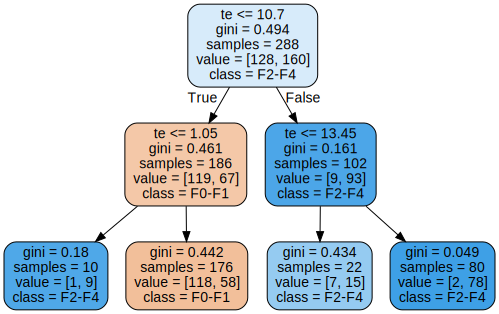

In [102]:
try:
    from graphviz import Source
    from sklearn.tree import export_graphviz

    tree = cross_validate(clf_tree, X=_X, y=_y, cv=5,  scoring=scoring, return_estimator=True)

    fname_tree_dot = os.path.join('figures', "decision_tree.dot")

    export_graphviz(
            tree['estimator'][0],
            out_file=fname_tree_dot,
            feature_names=['te'],
            class_names=['F0-F1', 'F2-F4'],
            rounded=True,
            filled=True
        )
    display(Source.from_file(fname_tree_dot))
except ModuleNotFoundError as e:
    print("Error:", e)
    pass
except Exception as e:
    print("Error:", e)
    pass

In [103]:
tree['estimator'][0].random_state

42

#### Rebuild `run_cv_binary` to get roc_curve value

The re-implemented interface for `run_cv_binary` has a a similar interface as sklearns [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html). The `group` parameter is missing as it's not used currently in this setup.

In [104]:
from collections import defaultdict
from collections.abc import Iterable

from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RepeatedStratifiedKFold

CV_FOLDS = 5
CV_REPEATS = 10
# RANDOM_SEED = 0



def run_cv_binary(clf_dict:dict, X:pd.DataFrame, y:pd.Series,
                  scoring=scorer_dict,
                  cv=None,
                  verbose=False,
                  prefix='')-> dict:
    """Run Cross Validation (cv) for binary classification example
    for a set of classifiers.
    
    
    Inputs
    ------
    clf_dict: dict
        Dictionary with keys and scikit-learn classifiers as values.
    X: 2D-array, pd.DataFrame
        Input data
    y: 1D-array, pd.Series
        Targets for classification
    splits: List of pandas.Index tuples denoting global training and test indices.
    cv: int, cross-validation generator or an iterable, default=None
        Number of splits for Cross-Validation.
    prefix: str
        Prefix for clf-key for custom naming.
    
    Returns
    -------
    dict: dict with keys of clf_dict and computed results for each run. 
    """
    cv_results = {}
    roc_curve_results = defaultdict(list)
    precision_recall_results = defaultdict(list)
   
    if cv is None:
        raise ValueError("Please provide an Iterable of pandas.Index tuples or integer")
    elif isinstance(cv, int):
         rskf = RepeatedStratifiedKFold(n_splits=cv, n_repeats=CV_REPEATS, random_state=RANDOM_SEED) 
         cv_train_test_indices = rskf.split(X, y)
         cv_train_test_indices = [(X.index[train_indices], X.index[test_indices]) for train_indices, test_indices in cv_train_test_indices]
         logging.warning('Splits based on provided data to fit, not globally. Do not compare between models.')
    elif isinstance(cv, Iterable):
        cv_train_test_indices = cv
    
    for key_clf, clf in clf_dict.items():
        key_clf = prefix + key_clf
        
        _cv_results = defaultdict(list)
        
        for i, (train_index, test_index) in enumerate(cv_train_test_indices):
            X_train = X.loc[X.index.intersection(train_index)]
            X_test = X.loc[X.index.intersection(test_index)]
            y_train = y.loc[y.index.intersection(train_index)]
            y_test = y.loc[y.index.intersection(test_index)]
            
            # drop-na only here, not before passing to the CV helper fct
            # this will garuantuee that for each run the clf are 
            # trained at least on a precisly defined subset
            
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_score = clf.predict_proba(X_test)
            
            for metric_name, metric_fct in scorer_dict.items():
                if metric_name == 'roc_auc':
                    _cv_results[metric_name].append(metric_fct(y_test, y_score[:,1]))
                else:
                    _cv_results[metric_name].append(metric_fct(y_test, y_pred))

            _cv_results['num_feat'].append(X.shape[-1])
            _cv_results['n_obs'].append(len(y))
            if verbose:
                _cv_results['prop_y_train'].append(y_train.mean())
                _cv_results['prot_y_test'].append(y_test.mean())

            
            fpr, tpr, cutoffs = roc_curve(y_test, y_score[:, 1])
            roc_curve_results[key_clf].append((fpr, tpr, cutoffs))
            _cv_results['roc_auc_2'].append(auc(fpr, tpr))
            
            precision, recall, thresholds = precision_recall_curve(y_test, y_score[:, 1])
            average_precision = sklm.average_precision_score(y_test, y_score[:, 1])
            precision_recall_results[key_clf].append((precision, recall, thresholds, average_precision))

        cv_results[key_clf] = dict(_cv_results)
        
    return cv_results, dict(roc_curve_results), dict(precision_recall_results)
results_dict, roc_curve_results, precision_recall_results = run_cv_binary(clf, X=_X, y=_y, cv=cv_train_test_indices, prefix='F2_')

Display CV results (metrics):

In [105]:
_get_cv_means(results_dict)

variable    precision              recall                  f1           \
statistics       mean       std      mean       std      mean      std   
F2_Logistic  0.827898  0.080989  0.712334  0.051796  0.762408  0.04313   
F2_f2_te     0.762146  0.058814  0.764471  0.045125  0.761687  0.04019   

variable    balanced_accuracy             roc_auc           num_feat       \
statistics               mean       std      mean       std     mean  std   
F2_Logistic          0.761788  0.047334  0.816744  0.034120      1.0  0.0   
F2_f2_te             0.731768  0.041798  0.731768  0.041798      1.0  0.0   

variable     n_obs      roc_auc_2            
statistics    mean  std      mean       std  
F2_Logistic  360.0  0.0  0.816744  0.034120  
F2_f2_te     360.0  0.0  0.731768  0.041798

Plot ROC curves of these CV runs

Using Stratified Splitting is default for [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate).

In [106]:
cv_results = {}
for key, _clf in clf_sklearn.items(): 
    cv_results[key] = cross_validate(_clf, X=_X, y=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=RANDOM_SEED), scoring=scoring)

In [107]:
_get_cv_means(cv_results)

variable   fit_time          score_time           test_balanced_accuracy  \
statistics     mean      std       mean       std                   mean   
Logistic     0.0024  0.00053   0.005766  0.000947               0.760875   

variable               test_f1           test_precision           test_recall  \
statistics       std      mean       std           mean       std        mean   
Logistic    0.038468  0.764372  0.037614       0.827215  0.059062      0.7155   

variable             test_roc_auc            
statistics       std         mean       std  
Logistic    0.061419     0.817187  0.037705

#### Learn imputation on fold?
Include Preprocessing (here: imputation into the pipeline). 

> write custom [`FunctionTransformer`](https://scikit-learn.org/stable/modules/preprocessing.html#custom-transformers) to included preprocessing.


In [108]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

def custom_preprocessing_function(X):
    """Operate on a a set of rows from the dataset.
    here: apply imputation to log-transformed values?
    """
    raise NotImplementedError

# clf = make_pipeline( FunctionTransformer(custom_preprocessing_function), svm.SVC(C=1))
# cross_val_score(clf, X, y, cv=cv)

#### Comment: Feature Selection
- Yes recursive feature selection would be good. I tried forward feature selection before to see where score matrix (e.g test-auc) reaches a plateau. In the end I decided a strategy to first select best 10 features based on auc, then perform a greedy search against all n-feature combos among the 10, then select the best feature combo based on MCC score. Afterwards I validate on the validation dataset which I stratified-split at the beginning.

To add
-  [x] Stratification of input data
-  [ ] Recursive feature selection
-  [ ] cutoff determination for binary classification (ROC-Curves, Precision-Recall-Curves)
    - needs a validation split

[Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) based on mutual information

## Individual Models for three endpoints fibrosis, steatosis and inflammation
Strategy for feature selection and model performance validation: 3 models to be built, fibrosis (F0-1 vs. F2-4, and F0-2 vs. F3-4), inflammation (0-1 vs. 2-5) and steatosis (0 vs. >0). Then compare each model with their respective existing best-in-class markers according to their standard cut-offs in clinic. 

In [109]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

class FeatureSelector():
    """Namespace for feature selection.
    Uses mutal information to select k best features. 
    Can combine the best for a set of targets to a combined maximum.
    
    Parameters
    ----------
    k: int
        top-k features for each endpoint
    protein_gene_data: pandas.DataFrame (shape: X_N, 1)
        Optional mapping of index of DataFrame passed to fit method
        to values in protein_gene_data. Here this is the associated gene-name
        to a protein.
    
    """
    
    def __init__(self, k=10, protein_gene_data=None):
        self.k = k
        self.protein_gene_id = protein_gene_data
        if protein_gene_data is not None:
            self.endpoints_features_ = pd.DataFrame()
        else:
            self.endpoints_features_ = None
        
    def fit(self, X: pd.DataFrame, y: pd.Series, col_name='target'):
        mask_samples_in_both = X.index.intersection(y.index)
        k_best = SelectKBest(mutual_info_classif, k=self.k)
        k_best.fit(X.loc[mask_samples_in_both], y=y.loc[mask_samples_in_both])
        
        selected_ = k_best.get_support()
        selected_ = X.columns[selected_]
        result = key_ProteinID.loc[selected_]
        result = result.fillna('NoGene')
        result.columns = [col_name]
        if self.endpoints_features_ is not None:
            self.endpoints_features_ = self.endpoints_features_.join(result, how='outer')
        else:
            print("Not able to aggregate as no protein_gene_data was passed.")
        return result
    

### Screen for optimized number of features

In [110]:
RECALCULATE_FEATURES = False
RESULT_FEATURE_COMPARISON = os.path.join(DATAFOLDER, 'summary_n_features.pkl')
def main_n_features_comparison():
    "compare performance using an grid of features"      
    from tqdm.notebook import tqdm as tqdm
    summary = []
    for n_features in tqdm(range(1,50)): 
        feature_selected = FeatureSelector(k=n_features, protein_gene_data=key_ProteinID)
        proteins_selected_f2 = feature_selected.fit(data_proteomics, kleiner_ge_2, 'F2')
        proteins_selected_f3 = feature_selected.fit(data_proteomics, kleiner_ge_3, 'F3')
        proteins_selected_s1 = feature_selected.fit(data_proteomics, steatosis_ge_1, 'S1')
        proteins_selected_I2 = feature_selected.fit(data_proteomics, inflamation_ge_2, 'I2')
        test_cases = {}
        test_cases['F2'] = {'proteins':proteins_selected_f2,'y':kleiner_ge_2}
        test_cases['F3'] = {'proteins':proteins_selected_f3,'y':kleiner_ge_3}
        test_cases['S1'] = {'proteins':proteins_selected_s1,'y':steatosis_ge_1}
        test_cases['I2'] = {'proteins':proteins_selected_I2,'y':inflamation_ge_2}
        for test_case in test_cases.keys():
            _clf = skllm.LogisticRegression(random_state=0, solver='liblinear')
            proteins_selected = test_cases[test_case]['proteins']
            y = test_cases[test_case]['y']
            _X = data_proteomics[proteins_selected.index]
            in_both = y.index.intersection(_X.index)
            _X = _X.loc[in_both]
            _y = y.loc[in_both]
            result = cross_validate(_clf, X=_X, y=_y, groups=_y, cv=RepeatedStratifiedKFold(n_splits=CV_FOLDS, n_repeats=CV_REPEATS, random_state=RANDOM_SEED) , scoring=scoring)
            result['name'] = _clf.__class__.__name__
            result['n_features'] = n_features
            result['test_case'] = test_case
            summary.append(pd.DataFrame(result))
            summary = [pd.DataFrame(_) for _ in summary]
            summary_n_features = pd.concat(summary)
            summary_n_features.to_pickle(RESULT_FEATURE_COMPARISON) # long format
    return summary_n_features
if not RECALCULATE_FEATURES:
    try:
        summary_n_features = pd.read_pickle(RESULT_FEATURE_COMPARISON)
    except FileNotFoundError:
        summary_n_features = main_n_features_comparison()
else:
    summary_n_features = main_n_features_comparison() 

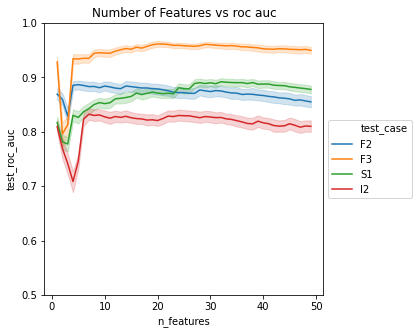

In [111]:
plt.figure(figsize=(5,5))
sns.lineplot(x='n_features',y='test_roc_auc',hue='test_case', data=summary_n_features)
plt.ylim([0.5,1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Number of Features vs roc auc')
plt.show()

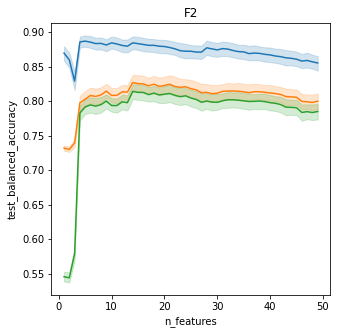

In [112]:
test_case='F2'
data=summary_n_features[summary_n_features['test_case']==test_case]
plt.figure(figsize=(5,5))
paras = ['test_roc_auc', 'test_f1', 'test_balanced_accuracy']
for p in paras:
    sns.lineplot(x='n_features', y=p, data=data)
    plt.title(test_case)

In [113]:
combined = summary_n_features.groupby(['test_case','n_features']).mean()

best = combined.sort_values(by='test_f1', ascending=False).groupby('test_case').head(1)
best

,,fit_time,score_time,test_precision,test_recall,test_f1,test_balanced_accuracy,test_roc_auc
test_case,n_features,,,,,,,
S1,36,0.003820,0.005482,0.835592,0.834154,0.833322,0.810410,0.890522
F3,21,0.003060,0.005280,0.878523,0.788012,0.828084,0.874383,0.961464
F2,14,0.003418,0.006847,0.850198,0.807103,0.826781,0.813955,0.884219
I2,9,0.002436,0.005395,0.782882,0.767553,0.772661,0.757290,0.831072


In [114]:
best_dict = {}
for i, j in best.index.to_list():
    best_dict[i] = j

### Top k selected proteins for prediction
[Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) based on mutual information. 

Each endpoint will yield different `top-k` proteins. An aggregation strategy in the simplest form is to combine the top-k. Maybe there is also some kind of rank-algorithm combining the top-k minimizing the overall rank?

In [115]:
end_points = ['F2', 'F3', 'S1', 'I2']
protein_panels={}
dichotomies = [kleiner_ge_2, kleiner_ge_3, steatosis_ge_1, inflamation_ge_2]

for i in range(4):
    end_point=end_points[i]
    k=best_dict[end_point]
    dichotomy=dichotomies[i]
    feature_selected = FeatureSelector(k=k, protein_gene_data=key_ProteinID)
    protein_panels[end_point] = feature_selected.fit(data_proteomics, dichotomy, end_point)

proteins_selected_f2=protein_panels['F2']
proteins_selected_f3=protein_panels['F3']
proteins_selected_s1=protein_panels['S1']
proteins_selected_I2=protein_panels['I2']

In [116]:
feature_selected.endpoints_features_

,I2
Protein ID,
O00391,QSOX1
P01833,PIGR
P05362,ICAM1
P05546,SERPIND1
P10643,C7
P10909,CLU
P23142,FBLN1
Q08380,LGALS3BP
Q16270,IGFBP7


In [117]:
feature_selected.endpoints_features_.notna().sum(axis=1)

Protein ID
O00391    1
P01833    1
P05362    1
P05546    1
P10643    1
P10909    1
P23142    1
Q08380    1
Q16270    1
dtype: int64

Selection could also be based on number of shared proteins being among the top 10. The degree of importance can be investigate. If the top10 for each endpoint are similar important selection based on the number of shared top-k between endpoints could be sensible.

In [118]:
proteins_selected = feature_selected.endpoints_features_.index[:10]
list(proteins_selected)

['O00391',
 'P01833',
 'P05362',
 'P05546',
 'P10643',
 'P10909',
 'P23142',
 'Q08380',
 'Q16270']

### Executor 

corresponds to main function in a script. Allows changes over all endpoints simultaneously. 

In [119]:
from sklearn.preprocessing import PolynomialFeatures
class MainExecutorCV():
    """Class to call cross-validation."""
    
    def __init__(self, proteomics_data:pd.DataFrame, clinical_data:pd.DataFrame, cutoffs_clinic, clf_sklearn, demographics:pd.DataFrame, endpoints_defined=['F2', 'F3', 'S1', 'I2']):
        self.data_proteomics = proteomics_data
        self.data_clinic = clinical_data
        self.cutoffs_clinic = cutoffs_clinic
        self.demographics = demographics.dropna()
        self.endpoints_defined = endpoints_defined
        self.clf_sklearn = clf_sklearn
    
    @staticmethod
    def cutoff_classifier(cutoffs:dict)-> dict:
        """Takes a dictionary of key:cutoff values and returns
        univariate ThresholdClassifiers for each key-cutoff-pair."""
        clf_threshold = {}
        for key, value in cutoffs.items():
            clf_threshold[key] = ThresholdClassifier(threshold={key:value})
        return clf_threshold

    def run_evaluation(self, y:pd.Series, endpoint:str, additional_markers:list, proteins_selected:pd.Index, add_demographics=False,
                       interactions_degree=1, verbose=False, evaluator_fct=run_cv_binary, cv=CV_FOLDS, n_repeats=CV_REPEATS):
        """Custom function to run standarda analysis for an endpoint based on 
        predefined cutoffs, specified clinical variables"""
        assert endpoint in self.endpoints_defined

        cutoffs_endpoint = cutoffs_clinic[endpoint].dropna().to_dict()
        clf_endpoint_threshold = self.cutoff_classifier(cutoffs_endpoint)
        if verbose: display(clf_endpoint_threshold)
        
        X = self.data_clinic.loc[y.index, cutoffs_clinic[endpoint].keys()]
        if verbose: display(X.describe())
            
        results = {}
        auc_scores = {}
        prc_scores = {}
        
        # Threshold Classifier (single clinical variable)
        for key, clf in clf_endpoint_threshold.items():
            _X = X[key].to_frame().dropna()
            _y = y.loc[_X.index].dropna()
            assert _X.isna().sum().sum() == 0
            assert _y.isna().sum() == 0

            _res, _auc_roc, _auc_prc = evaluator_fct({f'{endpoint}_marker_{key}':clf}, X=_X, y=_y, cv=cv)
            results.update(_res)
            auc_scores.update(_auc_roc)
            prc_scores.update(_auc_prc)

        #additional marker models (single clinical variable, trained)
        #add cutoff models based on data
        additional_markers.extend(list(cutoffs_endpoint.keys()))
        for key in additional_markers:
            _X, _y = self._select_features(X[key], y, add_demographics)
             
            for key_clf, clf in self.clf_sklearn.items():
                _res, _auc_roc, _auc_prc = evaluator_fct({f'{endpoint}_marker_{key}_{key_clf}':clf}, X=_X, y=_y, cv=cv)
                results.update(_res)
                auc_scores.update(_auc_roc)
                prc_scores.update(_auc_prc)
        
        #proteomics models (based on provided protein selection)
        _X, _y = self._select_features(self.data_proteomics[proteins_selected.index], y, add_demographics)
        
        #Add interaction to _X
        if interactions_degree>1:
            assert isinstance(interactions_degree, int), "Please pass an interaction_degree of type int, not {}".format(type(interactions_degree))
            poly_features = PolynomialFeatures(degree=interactions_degree, include_bias=False)
            _X = pd.DataFrame(poly_features.fit_transform(_X), index=_X.index)
               
        _res, _auc_roc, _auc_prc = evaluator_fct(self.clf_sklearn, X=_X, y=_y, prefix=f'{endpoint}_prot_', cv=cv)
        results.update(_res)
        auc_scores.update(_auc_roc)
        prc_scores.update(_auc_prc)

        return results, auc_scores, prc_scores
    
    def _select_features(self, X, y, add_demographics):
            if isinstance(X, pd.Series):
                X = X.to_frame()
            _X = X.dropna()
            in_both = y.index.intersection(_X.index)
            _X = _X.loc[in_both]
            _y = y.loc[in_both]
            
            if add_demographics:
                _index_tmp = _X.index
                _X = _X.join(self.demographics).dropna()
                _y = y.loc[_X.index]
                _intersection, _diff_to_1 = self._get_common_indices(_index_tmp, _X.index)

            assert _X.isna().sum().sum() == 0
            assert _y.isna().sum() == 0
            
            return _X, _y
    
    
    @staticmethod
    def _get_common_indices(index_1, index_2):
        _intersection = index_1.intersection(index_2)
        #assert len(_intersection) == len(_y.index), "Missing indices in feature data: {}".format(", ".join(_y.index.difference(_intersection)))
        _diff_to_1 = index_1.difference(_intersection)
        if len(_diff_to_1) > 1:
            logging.warning("Sample with clinical features not in demographics: {}".format(", ".join(_diff_to_1)))
        return _intersection, _diff_to_1

cv_executor = MainExecutorCV(proteomics_data=data_proteomics, clinical_data=data_cli, demographics=demographics, clf_sklearn=clf_sklearn, cutoffs_clinic=cutoffs_clinic)

1. Models based on clinical marker thresholds (Clinical Reference Models) - defined by `cutoffs_clinic`
2. Additional Models based on clinical markers (having no standard cutoffs defined or if data dependent cutoff is wanted) - defined by list `additional_markers`
    - As this depends on the endpoint, it is 
3. Proteomics Models based on protein intensities

Performance depends on the number of available features (varies!) 

### Fibrosis

#### F2

In [120]:
kleiner_ge_2.value_counts(dropna=False)

1    200
0    160
Name: kleiner, dtype: int64

In [121]:
cutoffs_f2 = cutoffs_clinic['F2'].dropna().to_dict()
cutoffs_f2

{'te': 7.0, 'swe': 8.6, 'elf': 7.7, 'ft': 0.48, 'fib4': 1.45, 'apri': 0.5}

In [122]:
y = kleiner_ge_2.astype(int)
y.describe()

count    360.000000
mean       0.555556
std        0.497596
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: kleiner, dtype: float64

In [123]:
ADD_DEMOGRAPHICS = True
f2_results, f2_auc_scores, f2_prc_scores = cv_executor.run_evaluation(y=kleiner_ge_2,
                                                       endpoint='F2',
                                                       additional_markers=['forns', 'p3np'],
                                                       proteins_selected=proteins_selected_f2,
                                                       add_demographics=ADD_DEMOGRAPHICS,
                                                       cv=cv_train_test_indices,
                                                       interactions_degree=2,
                                                       verbose=True)
result_table_f2 = _get_cv_means(f2_results).sort_values(('f1', 'mean'), ascending = False)
result_table_f2

{'te': ThresholdClassifier(cutoff=0.5, threshold={'te': 7.0}),
 'swe': ThresholdClassifier(cutoff=0.5, threshold={'swe': 8.6}),
 'elf': ThresholdClassifier(cutoff=0.5, threshold={'elf': 7.7}),
 'ft': ThresholdClassifier(cutoff=0.5, threshold={'ft': 0.48}),
 'fib4': ThresholdClassifier(cutoff=0.5, threshold={'fib4': 1.45}),
 'apri': ThresholdClassifier(cutoff=0.5, threshold={'apri': 0.5})}

marker,te,swe,elf,ft,fib4,apri,forns,p3np,m30,m65,aar,cap
count,341.000000,331.000000,349.000000,268.000000,352.000000,353.000000,356.000000,319.000000,268.000000,266.000000,352.000000,205.000000
mean,16.260704,13.842900,9.777650,0.347351,2.534773,0.703683,5.630197,13.279937,233.677756,685.670989,1.367727,287.107317
std,18.386198,11.711420,1.510562,0.286632,3.027889,0.992125,2.394013,12.439905,297.008804,850.377366,0.764461,63.930402
min,2.100000,2.100000,6.900000,0.020000,0.270000,0.080000,-1.540000,1.500000,2.126260,82.780701,0.090000,100.000000
25%,5.600000,6.500000,8.700000,0.100000,0.950000,0.240000,4.012500,6.750000,95.456402,271.321750,0.877500,245.000000
50%,8.700000,8.700000,9.400000,0.245000,1.570000,0.400000,5.515000,9.000000,153.139500,440.100005,1.130000,286.000000
75%,18.200001,15.850000,10.700000,0.542500,2.892500,0.770000,7.142500,14.450000,261.165740,835.044495,1.640000,331.000000
max,75.000000,75.599998,14.800000,0.980000,32.700001,11.630000,12.580000,112.500000,3816.990000,10015.900000,4.710000,400.000000


C:\Users\kzl465\Anaconda3\envs\ald_study\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\kzl465\Anaconda3\envs\ald_study\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


variable                 precision              recall                  f1  \
statistics                    mean       std      mean       std      mean   
F2_marker_te              0.762146  0.058814  0.822419  0.044639  0.789424   
F2_marker_ft_Logistic     0.847538  0.078449  0.739539  0.078768  0.786167   
F2_marker_swe             0.795361  0.046785  0.777841  0.047486  0.785331   
F2_prot_Logistic          0.783681  0.057169  0.769583  0.046149  0.774968   
F2_marker_te_Logistic     0.852981  0.065758  0.709427  0.067838  0.771100   
F2_marker_swe_Logistic    0.841276  0.054687  0.697281  0.059542  0.760467   
F2_marker_elf_Logistic    0.739196  0.081626  0.770562  0.059978  0.751121   
F2_marker_fib4            0.744125  0.059740  0.743563  0.055744  0.742442   
F2_marker_forns_Logistic  0.737861  0.077395  0.742772  0.068109  0.736589   
F2_marker_elf             0.572616  0.053376  0.994715  0.010631  0.725415   
F2_marker_p3np_Logistic   0.796405  0.081830  0.671332  0.088794  0.723264   
F2_marker_fib4_Logistic   0.780723  0.066782  0.668651  0.072283  0.716528   
F2_marker_apri_Logistic   0.719598  0.078667  0.709279  0.070626  0.710254   
F2_marker_apri            0.835831  0.074282  0.565735  0.077255  0.670714   
F2_marker_ft              0.908977  0.078224  0.492372  0.063814  0.635908   

variable                           balanced_accuracy             roc_auc  \
statistics                     std              mean       std      mean   
F2_marker_te              0.039629          0.755953  0.041679  0.755953   
F2_marker_ft_Logistic     0.058187          0.794808  0.053297  0.848619   
F2_marker_swe             0.036331          0.768731  0.037590  0.768731   
F2_prot_Logistic          0.037521          0.752476  0.040639  0.823675   
F2_marker_te_Logistic     0.045010          0.779491  0.043022  0.866511   
F2_marker_swe_Logistic    0.043272          0.769817  0.039652  0.864000   
F2_marker_elf_Logistic    0.051249          0.717272  0.053987  0.810422   
F2_marker_fib4            0.048656          0.711309  0.045278  0.711309   
F2_marker_forns_Logistic  0.052083          0.707829  0.053925  0.804645   
F2_marker_elf             0.043816          0.532734  0.025704  0.532734   
F2_marker_p3np_Logistic   0.063576          0.737057  0.051705  0.805516   
F2_marker_fib4_Logistic   0.050626          0.717479  0.042175  0.778501   
F2_marker_apri_Logistic   0.052777          0.682859  0.053629  0.759382   
F2_marker_apri            0.065762          0.713382  0.044433  0.713382   
F2_marker_ft              0.060212          0.719264  0.040950  0.719264   

variable                           num_feat       n_obs      roc_auc_2  \
statistics                     std     mean  std   mean  std      mean   
F2_marker_te              0.041679      1.0  0.0  341.0  0.0  0.755953   
F2_marker_ft_Logistic     0.049217      4.0  0.0  267.0  0.0  0.848619   
F2_marker_swe             0.037590      1.0  0.0  331.0  0.0  0.768731   
F2_prot_Logistic          0.034066    170.0  0.0  356.0  0.0  0.823675   
F2_marker_te_Logistic     0.029569      4.0  0.0  340.0  0.0  0.866511   
F2_marker_swe_Logistic    0.029346      4.0  0.0  330.0  0.0  0.864000   
F2_marker_elf_Logistic    0.045720      4.0  0.0  347.0  0.0  0.810422   
F2_marker_fib4            0.045278      1.0  0.0  352.0  0.0  0.711309   
F2_marker_forns_Logistic  0.047340      4.0  0.0  354.0  0.0  0.804645   
F2_marker_elf             0.025704      1.0  0.0  349.0  0.0  0.532734   
F2_marker_p3np_Logistic   0.052680      4.0  0.0  317.0  0.0  0.805516   
F2_marker_fib4_Logistic   0.045409      4.0  0.0  350.0  0.0  0.778501   
F2_marker_apri_Logistic   0.057454      4.0  0.0  351.0  0.0  0.759382   
F2_marker_apri            0.044433      1.0  0.0  353.0  0.0  0.713382   
F2_marker_ft              0.040950      1.0  0.0  268.0  0.0  0.719264   

variable                            
statistics                     std  
F2_marker_te              0.041679  
F2_marker_

In [124]:
ADD_DEMOGRAPHICS = False
f2_results, f2_auc_scores, f2_prc_scores = cv_executor.run_evaluation(y=kleiner_ge_2,
                                                       endpoint='F2',
                                                       additional_markers=['forns', 'p3np'],
                                                       proteins_selected=proteins_selected_f2,
                                                       add_demographics=ADD_DEMOGRAPHICS,
                                                       interactions_degree=1,
                                                       cv=cv_train_test_indices,
                                                       verbose=False)
result_table_f2 = _get_cv_means(f2_results).sort_values(('f1', 'mean'), ascending = False)
result_table_f2

variable                 precision              recall                  f1  \
statistics                    mean       std      mean       std      mean   
F2_prot_Logistic          0.846504  0.059991  0.801482  0.058137  0.820944   
F2_marker_te              0.762146  0.058814  0.822419  0.044639  0.789424   
F2_marker_elf_Logistic    0.762396  0.075721  0.825852  0.065125  0.788493   
F2_marker_te_Logistic     0.857752  0.071007  0.731610  0.065626  0.786099   
F2_marker_swe             0.795361  0.046785  0.777841  0.047486  0.785331   
F2_marker_ft_Logistic     0.847062  0.075182  0.736617  0.085997  0.783644   
F2_marker_swe_Logistic    0.856950  0.042235  0.710816  0.052951  0.775568   
F2_marker_forns_Logistic  0.722146  0.067358  0.774115  0.063164  0.744214   
F2_marker_fib4            0.744125  0.059740  0.743563  0.055744  0.742442   
F2_marker_p3np_Logistic   0.819726  0.078364  0.668759  0.091848  0.731047   
F2_marker_elf             0.572616  0.053376  0.994715  0.010631  0.725415   
F2_marker_apri_Logistic   0.797279  0.091786  0.665588  0.084002  0.718946   
F2_marker_fib4_Logistic   0.786230  0.072759  0.668902  0.075037  0.718199   
F2_marker_apri            0.835831  0.074282  0.565735  0.077255  0.670714   
F2_marker_ft              0.908977  0.078224  0.492372  0.063814  0.635908   

variable                           balanced_accuracy             roc_auc  \
statistics                     std              mean       std      mean   
F2_prot_Logistic          0.039667          0.807893  0.044190  0.881211   
F2_marker_te              0.039629          0.755953  0.041679  0.755953   
F2_marker_elf_Logistic    0.041526          0.751057  0.046520  0.852217   
F2_marker_te_Logistic     0.045046          0.790544  0.047098  0.873881   
F2_marker_swe             0.036331          0.768731  0.037590  0.768731   
F2_marker_ft_Logistic     0.058547          0.793053  0.053424  0.864336   
F2_marker_swe_Logistic    0.036432          0.783688  0.034730  0.880335   
F2_marker_forns_Logistic  0.046390          0.700957  0.051086  0.808655   
F2_marker_fib4            0.048656          0.711309  0.045278  0.711309   
F2_marker_p3np_Logistic   0.064906          0.750136  0.050827  0.805469   
F2_marker_elf             0.043816          0.532734  0.025704  0.532734   
F2_marker_apri_Logistic   0.060241          0.726158  0.053216  0.766461   
F2_marker_fib4_Logistic   0.050524          0.719714  0.041802  0.786277   
F2_marker_apri            0.065762          0.713382  0.044433  0.713382   
F2_marker_ft              0.060212          0.719264  0.040950  0.719264   

variable                           num_feat       n_obs      roc_auc_2  \
statistics                     std     mean  std   mean  std      mean   
F2_prot_Logistic          0.032088     14.0  0.0  358.0  0.0  0.881211   
F2_marker_te              0.041679      1.0  0.0  341.0  0.0  0.755953   
F2_marker_elf_Logistic    0.038302      1.0  0.0  349.0  0.0  0.852217   
F2_marker_te_Logistic     0.030126      1.0  0.0  341.0  0.0  0.873881   
F2_marker_swe             0.037590      1.0  0.0  331.0  0.0  0.768731   
F2_marker_ft_Logistic     0.041966      1.0  0.0  268.0  0.0  0.864336   
F2_marker_swe_Logistic    0.025642      1.0  0.0  331.0  0.0  0.880335   
F2_marker_forns_Logistic  0.044753      1.0  0.0  356.0  0.0  0.808655   
F2_marker_fib4            0.045278      1.0  0.0  352.0  0.0  0.711309   
F2_marker_p3np_Logistic   0.045167      1.0  0.0  319.0  0.0  0.805469   
F2_marker_elf             0.025704      1.0  0.0  349.0  0.0  0.532734   
F2_marker_apri_Logistic   0.050123      1.0  0.0  353.0  0.0  0.766461   
F2_marker_fib4_Logistic   0.042852      1.0  0.0  352.0  0.0  0.786277   
F2_marker_apri            0.044433      1.0  0.0  353.0  0.0  0.713382   
F2_marker_ft              0.040950      1.0  0.0  268.0  0.0  0.719264   

variable                            
statistics                     std  
F2_prot_Logistic          0.032088  
F2_marker_

In [125]:
ADD_DEMOGRAPHICS = True
f2_results, f2_auc_scores, f2_prc_scores = cv_executor.run_evaluation(y=kleiner_ge_2,
                                                       endpoint='F2',
                                                       additional_markers=['forns', 'p3np'],
                                                       proteins_selected=proteins_selected_f2,
                                                       add_demographics=ADD_DEMOGRAPHICS,
                                                       interactions_degree=1,
                                                       cv=cv_train_test_indices,
                                                       verbose=False)
result_table_f2 = _get_cv_means(f2_results).sort_values(('f1', 'mean'), ascending = False)
result_table_f2

variable                 precision              recall                  f1  \
statistics                    mean       std      mean       std      mean   
F2_prot_Logistic          0.825955  0.066837  0.785840  0.052984  0.802808   
F2_marker_te              0.762146  0.058814  0.822419  0.044639  0.789424   
F2_marker_ft_Logistic     0.847538  0.078449  0.739539  0.078768  0.786167   
F2_marker_swe             0.795361  0.046785  0.777841  0.047486  0.785331   
F2_marker_te_Logistic     0.852981  0.065758  0.709427  0.067838  0.771100   
F2_marker_swe_Logistic    0.841276  0.054687  0.697281  0.059542  0.760467   
F2_marker_elf_Logistic    0.739196  0.081626  0.770562  0.059978  0.751121   
F2_marker_fib4            0.744125  0.059740  0.743563  0.055744  0.742442   
F2_marker_forns_Logistic  0.737861  0.077395  0.742772  0.068109  0.736589   
F2_marker_elf             0.572616  0.053376  0.994715  0.010631  0.725415   
F2_marker_p3np_Logistic   0.796405  0.081830  0.671332  0.088794  0.723264   
F2_marker_fib4_Logistic   0.780723  0.066782  0.668651  0.072283  0.716528   
F2_marker_apri_Logistic   0.719598  0.078667  0.709279  0.070626  0.710254   
F2_marker_apri            0.835831  0.074282  0.565735  0.077255  0.670714   
F2_marker_ft              0.908977  0.078224  0.492372  0.063814  0.635908   

variable                           balanced_accuracy             roc_auc  \
statistics                     std              mean       std      mean   
F2_prot_Logistic          0.038635          0.789227  0.043091  0.881119   
F2_marker_te              0.039629          0.755953  0.041679  0.755953   
F2_marker_ft_Logistic     0.058187          0.794808  0.053297  0.848619   
F2_marker_swe             0.036331          0.768731  0.037590  0.768731   
F2_marker_te_Logistic     0.045010          0.779491  0.043022  0.866511   
F2_marker_swe_Logistic    0.043272          0.769817  0.039652  0.864000   
F2_marker_elf_Logistic    0.051249          0.717272  0.053987  0.810422   
F2_marker_fib4            0.048656          0.711309  0.045278  0.711309   
F2_marker_forns_Logistic  0.052083          0.707829  0.053925  0.804645   
F2_marker_elf             0.043816          0.532734  0.025704  0.532734   
F2_marker_p3np_Logistic   0.063576          0.737057  0.051705  0.805516   
F2_marker_fib4_Logistic   0.050626          0.717479  0.042175  0.778501   
F2_marker_apri_Logistic   0.052777          0.682859  0.053629  0.759382   
F2_marker_apri            0.065762          0.713382  0.044433  0.713382   
F2_marker_ft              0.060212          0.719264  0.040950  0.719264   

variable                           num_feat       n_obs      roc_auc_2  \
statistics                     std     mean  std   mean  std      mean   
F2_prot_Logistic          0.029965     17.0  0.0  356.0  0.0  0.881119   
F2_marker_te              0.041679      1.0  0.0  341.0  0.0  0.755953   
F2_marker_ft_Logistic     0.049217      4.0  0.0  267.0  0.0  0.848619   
F2_marker_swe             0.037590      1.0  0.0  331.0  0.0  0.768731   
F2_marker_te_Logistic     0.029569      4.0  0.0  340.0  0.0  0.866511   
F2_marker_swe_Logistic    0.029346      4.0  0.0  330.0  0.0  0.864000   
F2_marker_elf_Logistic    0.045720      4.0  0.0  347.0  0.0  0.810422   
F2_marker_fib4            0.045278      1.0  0.0  352.0  0.0  0.711309   
F2_marker_forns_Logistic  0.047340      4.0  0.0  354.0  0.0  0.804645   
F2_marker_elf             0.025704      1.0  0.0  349.0  0.0  0.532734   
F2_marker_p3np_Logistic   0.052680      4.0  0.0  317.0  0.0  0.805516   
F2_marker_fib4_Logistic   0.045409      4.0  0.0  350.0  0.0  0.778501   
F2_marker_apri_Logistic   0.057454      4.0  0.0  351.0  0.0  0.759382   
F2_marker_apri            0.044433      1.0  0.0  353.0  0.0  0.713382   
F2_marker_ft              0.040950      1.0  0.0  268.0  0.0  0.719264   

variable                            
statistics                     std  
F2_prot_Logistic          0.029965  
F2_marker_

#### F3

In [126]:
kleiner_ge_3.value_counts(dropna=False)

0    266
1     94
Name: kleiner, dtype: int64

In [127]:
cutoffs_f3 = cutoffs_clinic['F3'].dropna().to_dict()
cutoffs_f3

{'te': 15.0,
 'swe': 16.4,
 'elf': 10.5,
 'ft': 0.58,
 'fib4': 3.25,
 'apri': 1.0,
 'forns': 6.8}

Two clinical markers have no cutoff defined in the literature. Therefore we have to learn these

In [128]:
f3_results, f3_auc_scores, f3_prc_scores = cv_executor.run_evaluation(y=kleiner_ge_3, endpoint='F3', 
                                                       additional_markers=['p3np'], 
                                                       proteins_selected=proteins_selected_f3,
                                                       cv=cv_train_test_indices)
result_table_f3 = _get_cv_means(f3_results).sort_values(('f1', 'mean'), ascending = False)
result_table_f3

C:\Users\kzl465\Anaconda3\envs\ald_study\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kzl465\Anaconda3\envs\ald_study\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kzl465\Anaconda3\envs\ald_study\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kzl465\Anaconda3\envs\ald_study\lib\site-packages\sklearn\met

variable                 precision              recall                  f1  \
statistics                    mean       std      mean       std      mean   
F3_marker_swe             0.854429  0.070118  0.830650  0.078179  0.839372   
F3_marker_te              0.792698  0.069710  0.892803  0.069463  0.837135   
F3_prot_Logistic          0.878035  0.067734  0.780296  0.090189  0.822877   
F3_marker_swe_Logistic    0.868544  0.071566  0.688866  0.105117  0.762115   
F3_marker_elf             0.700446  0.080648  0.756235  0.092639  0.723548   
F3_marker_te_Logistic     0.844441  0.101921  0.628232  0.122412  0.711150   
F3_marker_forns           0.641146  0.091177  0.701367  0.090099  0.666547   
F3_marker_ft              0.649244  0.124419  0.639678  0.119910  0.636884   
F3_marker_ft_Logistic     0.745515  0.124332  0.550805  0.132115  0.623538   
F3_marker_fib4            0.689596  0.101456  0.578024  0.112559  0.623239   
F3_marker_forns_Logistic  0.751787  0.105333  0.475861  0.104344  0.575827   
F3_marker_p3np_Logistic   0.758367  0.150833  0.428033  0.113038  0.536072   
F3_marker_elf_Logistic    0.928045  0.092593  0.373330  0.124273  0.517492   
F3_marker_apri            0.517708  0.111111  0.369575  0.105175  0.424569   
F3_marker_fib4_Logistic   0.679924  0.189368  0.233082  0.119424  0.331986   
F3_marker_apri_Logistic   0.452286  0.372242  0.063302  0.063913  0.104938   

variable                           balanced_accuracy             roc_auc  \
statistics                     std              mean       std      mean   
F3_marker_swe             0.054933          0.890900  0.039583  0.890900   
F3_marker_te              0.052948          0.907321  0.035261  0.907321   
F3_prot_Logistic          0.065896          0.870872  0.046586  0.961669   
F3_marker_swe_Logistic    0.071099          0.826115  0.048986  0.954326   
F3_marker_elf             0.067648          0.822176  0.047964  0.822176   
F3_marker_te_Logistic     0.092177          0.794095  0.060241  0.955308   
F3_marker_forns           0.078052          0.780144  0.051850  0.780144   
F3_marker_ft              0.102388          0.763014  0.066470  0.763014   
F3_marker_ft_Logistic     0.108304          0.744227  0.068282  0.904326   
F3_marker_fib4            0.091540          0.742825  0.059533  0.742825   
F3_marker_forns_Logistic  0.093642          0.709750  0.052236  0.843288   
F3_marker_p3np_Logistic   0.107091          0.692031  0.057823  0.842243   
F3_marker_elf_Logistic    0.129679          0.681220  0.060347  0.912007   
F3_marker_apri            0.096551          0.623425  0.055062  0.623425   
F3_marker_fib4_Logistic   0.141235          0.597392  0.054475  0.835499   
F3_marker_apri_Logistic   0.096758          0.519579  0.029910  0.784558   

variable                           num_feat       n_obs      roc_auc_2  \
statistics                     std     mean  std   mean  std      mean   
F3_marker_swe             0.039583      1.0  0.0  331.0  0.0  0.890900   
F3_marker_te              0.035261      1.0  0.0  341.0  0.0  0.907321   
F3_prot_Logistic          0.018533     21.0  0.0  358.0  0.0  0.961669   
F3_marker_swe_Logistic    0.021844      1.0  0.0  331.0  0.0  0.954326   
F3_marker_elf             0.047964      1.0  0.0  349.0  0.0  0.822176   
F3_marker_te_Logistic     0.023673      1.0  0.0  341.0  0.0  0.955308   
F3_marker_forns           0.051850      1.0  0.0  356.0  0.0  0.780144   
F3_marker_ft              0.066470      1.0  0.0  268.0  0.0  0.763014   
F3_marker_ft_Logistic     0.042261      1.0  0.0  268.0  0.0  0.904326   
F3_marker_fib4            0.059533      1.0  0.0  352.0  0.0  0.742825   
F3_marker_forns_Logistic  0.047350      1.0  0.0  356.0  0.0  0.843288   
F3_marker_p3np_Logistic   0.061500      1.0  0.0  319.0  0.0  0.842243   
F3_marker_elf_Logistic    0.029339      1.0  0.0  349.0  0.0  0.912007   
F3_marker_apri            0.055062      1.0  0.0  353.0  0.0  0.623425   
F3_marker_fib4_Logistic   0.048522      1.

If the models are trained on the fibrosis data only, on could expect some predictions of fibrosis patients in the untested healthy patient (hp) cohort.

#### Comment: Healthy patients - Select for testing
- Yes, that is a good idea. One can also predict on the test set and ask for a re-examination of the patient (or re-evaluation of the histology score), or to look into the outcome data which we might get access to soon. We might expect some "false prediction" to be "under-diagnosed" cases and vice versa.

#### Healthy vs Fibrosis patients

How many healthy patients would be predicted to have fibrosis?

#### Comment:
- I agree. Ideally we would need an independent cohort for validation but is not possible in this case. So we can split a validation cohort from the beginning, and leave it out of the entire machine learning process - feature selection, model building, parameter fine-tuning. The problem is with random split, there is still a factor of randomness...I doubt if it will be a good reflection of the model performance. Not sure if there is a better solution. Maybe we can split based on the year of sample collection. Something to have in mind. 

### Inflamation

In [129]:
inflamation_ge_2.value_counts(dropna=False)

1    189
0    163
Name: nas_inflam, dtype: int64

In [130]:
cutoffs_i2 = cutoffs_clinic['I2'].dropna().to_dict()
cutoffs_i2

{'aar': 2.0}

##### Reference Model: Based on clinical markerthresholds

In [131]:
i2_results, i2_auc_scores, i2_prc_scores = cv_executor.run_evaluation(y=inflamation_ge_2, endpoint='I2', 
                                                       additional_markers=['m30', 'm65'], 
                                                       proteins_selected=proteins_selected_I2,
                                                       cv=cv_train_test_indices)
result_table_i2 = _get_cv_means(i2_results).sort_values(('f1', 'mean'), ascending = False)
result_table_i2

variable               precision              recall                  f1  \
statistics                  mean       std      mean       std      mean   
I2_prot_Logistic        0.780286  0.062386  0.770973  0.082321  0.773043   
I2_marker_m30_Logistic  0.750955  0.079295  0.598920  0.090352  0.660540   
I2_marker_m65_Logistic  0.711886  0.092890  0.565195  0.101081  0.622286   
I2_marker_aar_Logistic  0.582355  0.075139  0.638826  0.108477  0.601389   
I2_marker_aar           0.812013  0.101973  0.211818  0.065796  0.331489   

variable                         balanced_accuracy             roc_auc  \
statistics                   std              mean       std      mean   
I2_prot_Logistic        0.058731          0.760441  0.052878  0.830920   
I2_marker_m30_Logistic  0.064601          0.692919  0.049309  0.767058   
I2_marker_m65_Logistic  0.072361          0.661573  0.058093  0.712705   
I2_marker_aar_Logistic  0.062112          0.552178  0.052614  0.594940   
I2_marker_aar           0.084720          0.577619  0.035828  0.577619   

variable                         num_feat       n_obs      roc_auc_2            
statistics                   std     mean  std   mean  std      mean       std  
I2_prot_Logistic        0.045252      9.0  0.0  350.0  0.0  0.830920  0.045252  
I2_marker_m30_Logistic  0.052376      1.0  0.0  266.0  0.0  0.767058  0.052376  
I2_marker_m65_Logistic  0.063415      1.0  0.0  264.0  0.0  0.712705  0.063415  
I2_marker_aar_Logistic  0.064549      1.0  0.0  344.0  0.0  0.594940  0.064549  
I2_marker_aar           0.035828      1.0  0.0  344.0  0.0  0.577619  0.035828

Data will have to depend on the number of available features in the 

Two clinical markers have no cutoff defined in the literature. Therefore we have to learn these

### Steatosis

In [132]:
steatosis_ge_1.value_counts(dropna=False)

1    196
0    156
Name: nas_steatosis_ordinal, dtype: int64

In [133]:
cutoffs_s1 = cutoffs_clinic['S1'].dropna().to_dict()
cutoffs_s1

{'cap': 290.0}

Data will have to depend on the number of available features in the 

In [134]:
y = steatosis_ge_1.astype(int)
y.describe()

count    352.000000
mean       0.556818
std        0.497468
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: nas_steatosis_ordinal, dtype: float64

In [135]:
s1_results, s1_auc_scores, s1_prc_scores = cv_executor.run_evaluation(y=steatosis_ge_1, endpoint='S1', 
                                                       additional_markers=[], 
                                                       proteins_selected=proteins_selected_s1,
                                                       cv=cv_train_test_indices)
result_table_s1 = _get_cv_means(s1_results).sort_values(('f1', 'mean'), ascending = False)
result_table_s1

variable               precision              recall                  f1  \
statistics                  mean       std      mean       std      mean   
S1_marker_cap_Logistic  0.751994  0.079818  0.930594  0.046601  0.828880   
S1_prot_Logistic        0.826012  0.078102  0.829321  0.067557  0.825073   
S1_marker_cap           0.888424  0.074085  0.633543  0.085213  0.735662   

variable                         balanced_accuracy             roc_auc  \
statistics                   std              mean       std      mean   
S1_marker_cap_Logistic  0.051501          0.689279  0.068952  0.826726   
S1_prot_Logistic        0.057006          0.805696  0.056977  0.885305   
S1_marker_cap           0.068282          0.749191  0.055883  0.749191   

variable                         num_feat       n_obs      roc_auc_2            
statistics                   std     mean  std   mean  std      mean       std  
S1_marker_cap_Logistic  0.057772      1.0  0.0  199.0  0.0  0.826726  0.057772  
S1_prot_Logistic        0.040026     36.0  0.0  350.0  0.0  0.885305  0.040026  
S1_marker_cap           0.055883      1.0  0.0  199.0  0.0  0.749191  0.055883

### Write results to Excel

In [136]:
FILE_RESULTS = 'results.xlsx'

with pd.ExcelWriter(FILE_RESULTS) as writer:
    result_table_f2.to_excel(writer, sheet_name='F2_featureOptim')
    result_table_f3.to_excel(writer, sheet_name='F3_featureOptim')
    result_table_i2.to_excel(writer, sheet_name='I2_featureOptim')
    result_table_s1.to_excel(writer, sheet_name='S1_featureOptim')

### Plot Results of three endpoints (F2, I2, S1)

- create [enumeration of subplots](https://stackoverflow.com/a/25544329/9684872) starting at a)

#### Performance Plots based on results DataFrame for a endpoint

In [137]:
display(result_table_s1)
result_table = result_table_s1
names = list(result_table.index)

def _process_names(index):
    names = list(index)
    names = [x.split('_') for x in names]
    endpoint = names[0][0]
    
    def _process_index_names(_l:list):
        if 'marker' in _l:
            _l.remove('marker')
        return _l
    
    for _l in names: assert endpoint == _l[0] , f"Mixed endpoints: {endpoint} and {_l[0]}"
    names = [" ".join(_process_index_names(_l[1:])).lower() for _l in names]
    return names
   
_process_names(result_table.index)

variable               precision              recall                  f1  \
statistics                  mean       std      mean       std      mean   
S1_marker_cap_Logistic  0.751994  0.079818  0.930594  0.046601  0.828880   
S1_prot_Logistic        0.826012  0.078102  0.829321  0.067557  0.825073   
S1_marker_cap           0.888424  0.074085  0.633543  0.085213  0.735662   

variable                         balanced_accuracy             roc_auc  \
statistics                   std              mean       std      mean   
S1_marker_cap_Logistic  0.051501          0.689279  0.068952  0.826726   
S1_prot_Logistic        0.057006          0.805696  0.056977  0.885305   
S1_marker_cap           0.068282          0.749191  0.055883  0.749191   

variable                         num_feat       n_obs      roc_auc_2            
statistics                   std     mean  std   mean  std      mean       std  
S1_marker_cap_Logistic  0.057772      1.0  0.0  199.0  0.0  0.826726  0.057772  
S1_prot_Logistic        0.040026     36.0  0.0  350.0  0.0  0.885305  0.040026  
S1_marker_cap           0.055883      1.0  0.0  199.0  0.0  0.749191  0.055883

['cap logistic', 'prot logistic', 'cap']

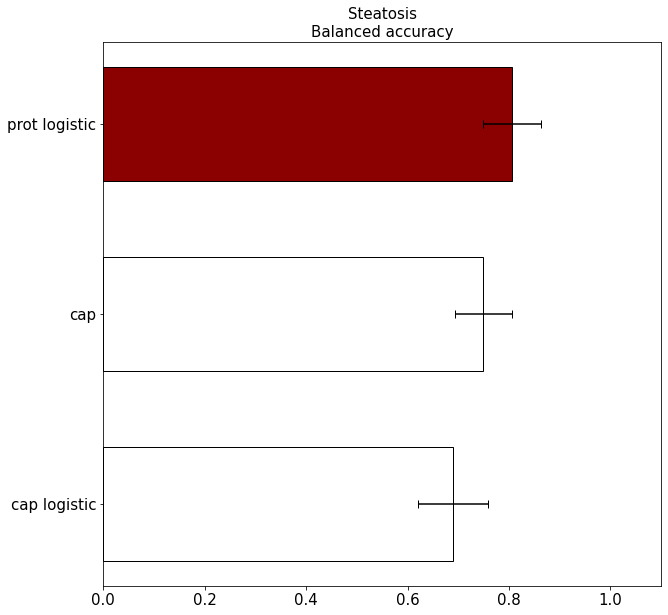

In [138]:
def plot_performance(ax, result, metric, title):
    '''result as result table from _get_cv_means(results)'''
    df = result.copy()
    df = df.sort_values(by = [(metric, 'mean')])
    colors = np.where(['prot' in row for row in df.index], 'darkred', 'white')
    df.index = _process_names(df.index)
    # fig, ax = plt.subplots(figsize=(3, 4))
    y = df.index
    width = df[(metric, 'mean')]
    xerr = df[(metric, 'std')]
    ax.set_xlim(0, 1.1)
    ax.tick_params(labelsize = 15)
    ax.barh(y=y, width=width, xerr=xerr, capsize=4, color=colors, height=0.6, edgecolor='black')
    
    metric_name = " ".join(metric.split('_')).capitalize()
    if metric == 'f1': metric_name += ' score'
    ax.set_title('{}\n{}'.format(title, metric_name), fontsize=15)

  
#  (result_table_s1, s1_auc_scores, 'NAS Steatosis >= 5%', 'S1_prot_Logistic')
    
fig, ax = plt.subplots(figsize=(10,10))
plot_performance(ax, result_table_s1, 'balanced_accuracy', 'Steatosis')

#### AUC-ROC Curves based on CV result for an endpoint

95% CI:(0.8116844242532462, 0.8283155757467537)


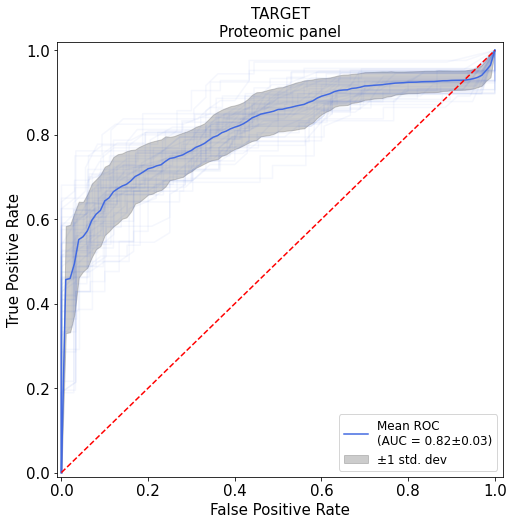

In [139]:
def plot_roc_curve(ax, runs_roc_auc_scores, endpoint=''):
        tprs = []
        base_fpr = np.linspace(0, 1, 101)
        roc_aucs = []
        for fpr, tpr, threshold in runs_roc_auc_scores:
            roc_auc = auc(fpr, tpr)
            roc_aucs.append(roc_auc)
            
            ax.plot(fpr, tpr, 'royalblue', alpha=0.05)
            
            tpr = np.interp(base_fpr, fpr, tpr)
            tpr[0]=0.0
            tprs.append(tpr)
    
        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std = tprs.std(axis=0)

        tprs_upper = mean_tprs + std
        tprs_lower = mean_tprs - std

        mean_rocauc = np.mean(roc_aucs).round(2)
        sd_rocauc = np.std(roc_aucs).round(2)
        se_rocauc = sd_rocauc/np.sqrt(len(roc_aucs))

        CI = (mean_rocauc-1.96 * se_rocauc, mean_rocauc + 1.96 * se_rocauc)

        ax.plot(base_fpr, mean_tprs, color = 'royalblue', 
                 label = 'Mean ROC\n(AUC = {}±{})'.format(mean_rocauc, sd_rocauc))
        ax.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.4, label = '±1 std. dev')

        ax.plot([0, 1], [0, 1],'r--')
        ax.set_xlim([-0.01, 1.02])
        ax.set_ylim([-0.01, 1.02])
        ax.set_ylabel('True Positive Rate', fontsize = 15)
        ax.set_xlabel('False Positive Rate', fontsize = 15)
        ax.tick_params(labelsize = 15)
        ax.legend(fontsize = 12)
        ax.set_title('{}\nProteomic panel'.format(endpoint), fontsize = 15)
        #  plt.savefig('figures/ROC_{}.pdf'.format(endpoint), dpi=120, bbox_inches='tight')
        print("95% CI:{}".format(CI))

fig, ax = plt.subplots(figsize=(8, 8))      
        
plot_roc_curve(ax, roc_curve_results['F2_Logistic'], 'TARGET')

#### Precision Recall Curve

95% CI:(0.8716844242532462, 0.8883155757467538)


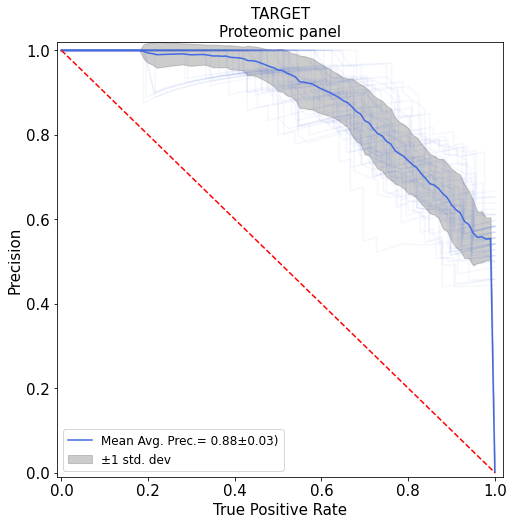

In [140]:
def plot_prc_curve(ax, runs_roc_auc_scores, endpoint=''):

    precisions = []
    base_recall = np.linspace(0, 1, 101)
    avg_precision = []
    for precision, recall, thresholds, _average_precision in runs_roc_auc_scores:

        avg_precision.append(_average_precision)

        ax.plot(recall, precision, 'royalblue', alpha=0.05)

        precision =  np.interp(base_recall, recall[::-1], precision[::-1])
        precision[-1]=0.0
        precisions.append(precision)
    ax.set(xlabel="Recall", ylabel="Precision")
    
        
    precisions = np.array(precisions)
    mean_precisions = precisions.mean(axis=0)
    std_precisions = precisions.std(axis=0)

    precisions_upper = mean_precisions + std_precisions
    precisions_lower = mean_precisions - std_precisions
    
    mean_avg_prec = np.mean(avg_precision).round(2)
    sd_avg_prec = np.std(avg_precision).round(2)
    se_avg_prec = sd_avg_prec/np.sqrt(len(avg_precision))

    CI = (mean_avg_prec-1.96 * se_avg_prec, mean_avg_prec + 1.96 * se_avg_prec)

    ax.plot(base_recall, mean_precisions, color = 'royalblue', 
             label = 'Mean Avg. Prec.= {}±{})'.format(mean_avg_prec, sd_avg_prec))
    ax.fill_between(base_recall, precisions_lower, precisions_upper, color='grey', alpha=0.4, label = '±1 std. dev')

    ax.plot([0, 1], [1, 0],'r--')
    ax.set_xlim([-0.01, 1.02])
    ax.set_ylim([-0.01, 1.02])
    ax.set_ylabel('Precision', fontsize = 15)
    ax.set_xlabel('True Positive Rate', fontsize = 15)
    ax.tick_params(labelsize = 15)
    ax.legend(fontsize = 12)
    ax.set_title('{}\nProteomic panel'.format(endpoint), fontsize = 15)
    #  plt.savefig('figures/ROC_{}.pdf'.format(endpoint), dpi=120, bbox_inches='tight')
    print("95% CI:{}".format(CI))
#     pos_label = estimator.classes_[1]
#     precision, recall, _ = precision_recall_curve(y, y_pred,
#                                                   pos_label=pos_label,
#                                                   sample_weight=sample_weight)
#     average_precision = average_precision_score(y, y_pred,
#                                                 pos_label=pos_label,
#                                                 sample_weight=sample_weight)
#     name = name if name is not None else estimator.__class__.__name__
#     viz = PrecisionRecallDisplay(
#         precision=precision, recall=recall,
#         average_precision=average_precision, estimator_name=name
#     )
#     return viz.plot(ax=ax, name=name, **kwargs)


fig, ax = plt.subplots(figsize=(8, 8))
plot_prc_curve(ax, precision_recall_results['F2_Logistic'], 'TARGET')

#### Build final figure for publication

95% CI:(0.8716844242532462, 0.8883155757467538)
95% CI:(0.8161407070887436, 0.8438592929112563)
95% CI:(0.878912565670995, 0.9010874343290051)


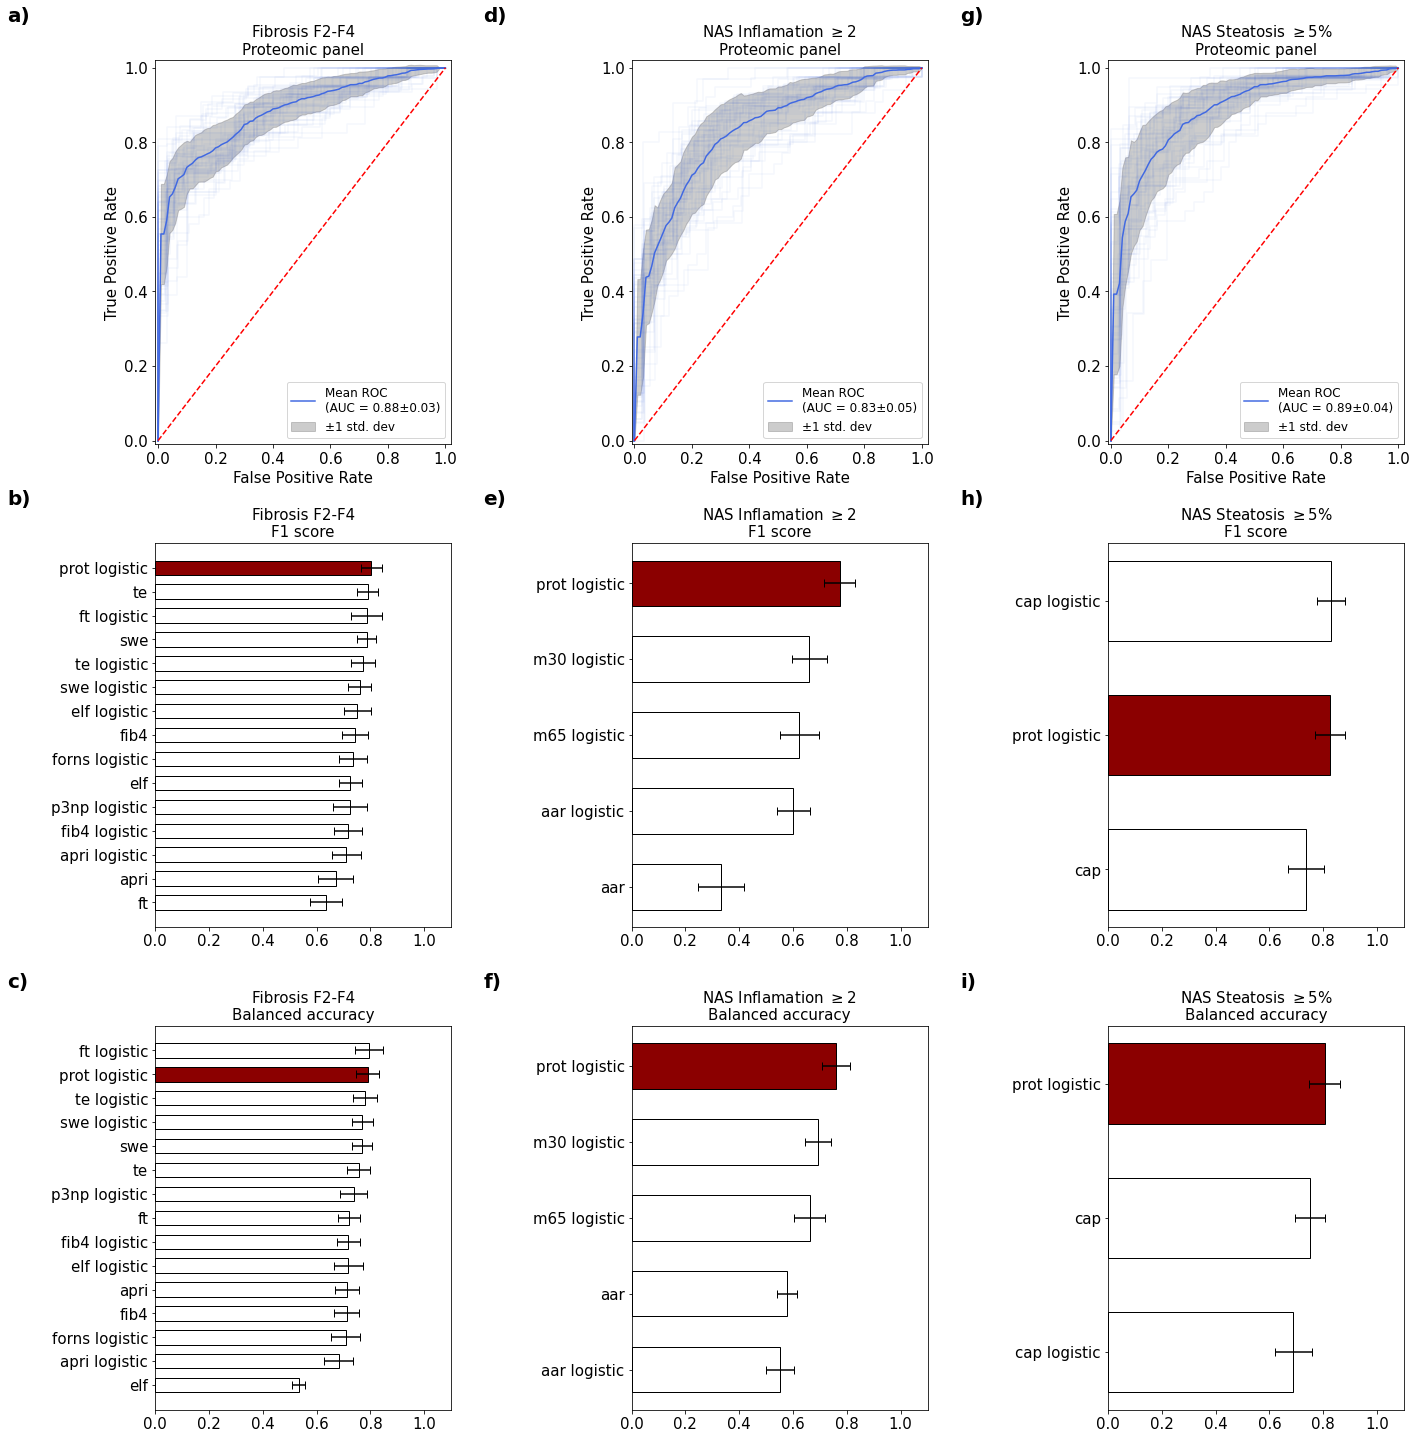

In [141]:
import string
fig, axs = plt.subplots(3,3,figsize=(20,20))

n=0
result_tuples = [
 (result_table_f2, f2_auc_scores, 'Fibrosis F2-F4', 'F2_prot_Logistic'), 
 (result_table_i2, i2_auc_scores, 'NAS Inflamation $\geq 2$', 'I2_prot_Logistic'), 
 (result_table_s1, s1_auc_scores, 'NAS Steatosis $\geq 5$%', 'S1_prot_Logistic')
]

for col, (result_table, result_auc_scores, endpoint_title, auc_model_name) in enumerate(result_tuples):
    
    ax = axs[0,col]
    plot_roc_curve(ax, result_auc_scores[auc_model_name], endpoint_title)
    _ = ax.text(-0.5, 1.1, f"{string.ascii_lowercase[n]})", transform=ax.transAxes, 
                size=20, weight='bold')
    n+=1
    
    ax = axs[1,col]
    plot_performance(ax, result=result_table, metric='f1', title=endpoint_title)   
    _ = ax.text(-0.5, 1.1, f"{string.ascii_lowercase[n]})", transform=ax.transAxes, 
                size=20, weight='bold')
    n+=1
    
    ax = axs[2,col]
    _ = ax.text(-0.5, 1.1, f"{string.ascii_lowercase[n]})", transform=ax.transAxes, 
                size=20, weight='bold')
    plot_performance(ax, result=result_table, metric='balanced_accuracy', title=endpoint_title)   

    n+=1

fig.tight_layout()
fig.savefig('figures/Figure_6.pdf', dpi=120, pad_inches=0.1, bbox_inches='tight')

## Multiclass, Multivariate Models
- predict single classes for each endpoint in a joint model.
- 

### Multiclass Fibrosis
- Predict 4 categories for fibrosis

In [142]:
kleiner_score = Y.kleiner.dropna()
y = kleiner_score

In [143]:
indices = data_proteomics.index.intersection(y.index)
X_train = data_proteomics.loc[indices]
y = y.loc[indices].astype(int)

In [144]:
clf_rf.fit(X_train, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=29, verbose=0,
                       warm_start=False)

In [145]:
clf_rf.classes_

array([0, 1, 2, 3, 4])

In [146]:
y_train_pred = sklms.cross_val_predict(clf_rf, X_train, y, cv=5)

In [147]:
conf_mx = sklm.confusion_matrix(y, y_train_pred)
conf_mx

array([[ 0, 34,  1,  0,  0],
       [ 0, 97, 26,  0,  1],
       [ 0, 45, 51,  0, 10],
       [ 0,  3, 12,  0, 12],
       [ 0,  0, 18,  0, 48]], dtype=int64)

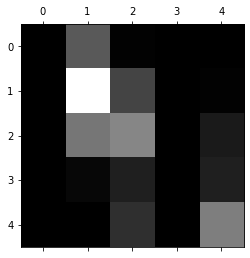

In [148]:
plt.matshow(conf_mx, cmap=plt.cm.gray) 
plt.show()

In [149]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
display(row_sums)
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[ 35],
       [124],
       [106],
       [ 27],
       [ 66]], dtype=int64)

array([[0.        , 0.97142857, 0.02857143, 0.        , 0.        ],
       [0.        , 0.78225806, 0.20967742, 0.        , 0.00806452],
       [0.        , 0.4245283 , 0.48113208, 0.        , 0.09433962],
       [0.        , 0.11111111, 0.44444444, 0.        , 0.44444444],
       [0.        , 0.        , 0.27272727, 0.        , 0.72727273]])

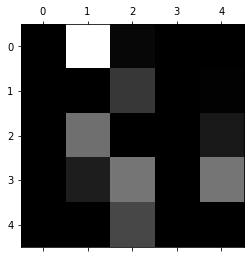

In [150]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [151]:
sklm.accuracy_score(y, y_train_pred)

0.547486033519553

### Final model

1. Either pick one of the models run during CV
2. Aggregate metrics over all CV runs for obs in test set (~ mean of CV results)
3. Perform new train/test split.


Steps to implement

1.  Select model with median aucroc performance
2.  Report summary statistics (mean, median, min, max)
3.  [DeLong](https://github.com/llniu/roc_comparison)
4.  Target Scores for three endpoints of final prediction model


#### Look at descriptive statistics of CV (Option 1/2)

- depending on the split the performance varies. The `min`, `max`, `mean`, etc. are given per model, therefore it's not the given split. Selecting a split of the data which supports one's conclusion can be misleading.

In [152]:
results = {
 "F2":f2_results,
 "F3":f3_results,
 "I2":i2_results,
 "S1":s1_results
}

In [153]:
results_combinded = {}
for _results in results.values(): results_combinded.update(_results)
results_combinded.keys()

dict_keys(['F2_marker_te', 'F2_marker_swe', 'F2_marker_elf', 'F2_marker_ft', 'F2_marker_fib4', 'F2_marker_apri', 'F2_marker_forns_Logistic', 'F2_marker_p3np_Logistic', 'F2_marker_te_Logistic', 'F2_marker_swe_Logistic', 'F2_marker_elf_Logistic', 'F2_marker_ft_Logistic', 'F2_marker_fib4_Logistic', 'F2_marker_apri_Logistic', 'F2_prot_Logistic', 'F3_marker_te', 'F3_marker_swe', 'F3_marker_elf', 'F3_marker_ft', 'F3_marker_fib4', 'F3_marker_apri', 'F3_marker_forns', 'F3_marker_p3np_Logistic', 'F3_marker_te_Logistic', 'F3_marker_swe_Logistic', 'F3_marker_elf_Logistic', 'F3_marker_ft_Logistic', 'F3_marker_fib4_Logistic', 'F3_marker_apri_Logistic', 'F3_marker_forns_Logistic', 'F3_prot_Logistic', 'I2_marker_aar', 'I2_marker_m30_Logistic', 'I2_marker_m65_Logistic', 'I2_marker_aar_Logistic', 'I2_prot_Logistic', 'S1_marker_cap', 'S1_marker_cap_Logistic', 'S1_prot_Logistic'])

In [154]:
def show_summary(results_dict, metric='f1', sort=True, save=False):
    _df = pd.DataFrame(results_dict).loc[metric].apply(pd.Series).T.describe()
    _df.index.name = metric
    if sort:
        _df = _df.sort_values(by='mean', axis=1, ascending=False)
    if save:
        fname = "cv_stats_{}{}.xlsx".format(metric, '_sorted' if save else '')
        fname = os.path.join(TABLEFOLDER, fname)
        _df.to_excel(fname)
        print(f'Saved Table to: {fname}')
    return _df

In [155]:
out= widgets.interact(show_summary, metric=scoring, results_dict=widgets.fixed(results_combinded))

interactive(children=(Dropdown(description='metric', index=2, options=('precision', 'recall', 'f1', 'balanced_…

### Select a model from the CV run (and compare it to others)

In [156]:
l_models = list(results_combinded.keys())
ref_model=l_models[14] # 'F2_prot_Logistic'
metric=scoring[2]      # 'f1'

In [157]:
def compare_models(ref_model:str, metric:str, data:dict, fct=np.median):
    """Select comparison. The first column is the referenc model.
    If the metric of the summary statistic is present several times in the model, this value is returned."""
    ref_model_metric_values = np.array(data[ref_model][metric])
    ref_model_metric = fct(ref_model_metric_values)
    ref_model_metric_idx = (np.abs(ref_model_metric_values - ref_model_metric)).argmin() #ToDo: return both closest values for median.
    ref_model_metric = ref_model_metric_values[ref_model_metric_idx]
    matches = [index for index, item in enumerate(ref_model_metric_values) if item == ref_model_metric]

    _results = pd.DataFrame(ref_model_metric_values[matches], columns=[ref_model], index=matches)
    _results.index.name = 'run'
    
    _selected_results = {}
    
    
    for _model, _result in data.items():
        if not _model == ref_model:
            _selected_results[_model] = [_result[metric][item] for item in matches]
    #sorting of values over last result
    _other = pd.DataFrame(_selected_results, index=matches)
    _other = _other.sort_values(by=matches[-1], axis=1, ascending=False)
    return _results.join(_other)

# l_models = list(results_combinded.keys())
# ref_model=l_models[14] # 'F2_prot_Logistic'
# metric=scoring[2]      # 'f1'
# compare_models(ref_model=ref_model, metric='precision', data=f2_results, fct=lambda x: np.quantile(x, q=0.6))

In [158]:
protein_model_name = {endpoint: f'{endpoint}_prot_Logistic'for endpoint in end_points}
metrics_np_fct = {'median': np.median, '3rd quintile': lambda x: np.quantile(x, q=0.6), 'mean': np.mean, 'max': np.max }

#needs global dictionaries: protein_model_name, metrics_np_fct, results
def _caller_comp(metric, endpoint, selector):
    """Helper function to use with ipykernel"""
    df = compare_models(ref_model=protein_model_name[endpoint], metric=metric, data=results[endpoint], fct=metrics_np_fct[selector])
    df.columns.name = selector
    return df
# _caller_comp('f1', 'I2', 'median')

In [159]:
out2= widgets.interact(_caller_comp, metric=scoring, endpoint=results.keys(), selector=metrics_np_fct.keys())

interactive(children=(Dropdown(description='metric', options=('precision', 'recall', 'f1', 'balanced_accuracy'…

#### Train a new final model

Adjust `run_cv_binary`

In [160]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(data_cli_missing_table, stratifier, test_size=0.2, random_state=42)

In [161]:
train_test_split_final = (X_train.index, X_test.index)

In [162]:
def run_binary_clfs(clf_dict:dict, X:pd.DataFrame, y:pd.Series, cv=None, 
                  scoring=scorer_dict, verbose=True,
                  prefix='')-> dict:
    """Run Cross Validation (cv) for binary classification example
    for a set of classifiers.
    
    
    Inputs
    ------
    clf_dict: dict
        Dictionary with keys and scikit-learn classifiers as values.
    X: 2D-array, pd.DataFrame
        Input data
    y: 1D-array, pd.Series
        Targets for classification
    cv: int
        Number of splits for Cross-Validation.
    prefix: str
        Prefix for clf-key for custom naming.
    
    Returns
    -------
    dict: dict with keys of clf_dict and computed results for each run. 
    """
    cv_results = {}
    roc_curve_results = defaultdict(list)
    precision_recall_results = defaultdict(list)
    
    if cv is None:
        raise ValueError("Please provide a set of train and test indices as a tuple of pandas.Index objects.")
    else:
        assert isinstance(cv, Iterable)
        train_index, test_index = cv
    
    for key_clf, clf in clf_dict.items():
        key_clf = prefix + key_clf
        
        _cv_results = defaultdict(int)

        # X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
        X_train = X.loc[X.index.intersection(train_index)]
        X_test = X.loc[X.index.intersection(test_index)]
        y_train = y.loc[y.index.intersection(train_index)]
        y_test = y.loc[y.index.intersection(test_index)]
            
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)

        for metric_name, metric_fct in scorer_dict.items():
            if metric_name == 'roc_auc':
                _cv_results[metric_name] = metric_fct(y_test, y_score[:,1])
            else:
                _cv_results[metric_name] = metric_fct(y_test, y_pred)

        _cv_results['num_feat'] = X.shape[-1]
        _cv_results['n_obs'] = len(y)
        if verbose:
            _cv_results['prop_y_train'] = y_train.mean()
            _cv_results['prot_y_test'] = y_test.mean()


        fpr, tpr, cutoffs = roc_curve(y_test, y_score[:, 1])
        roc_curve_results[key_clf].append((fpr, tpr, cutoffs))
        _cv_results['roc_auc_2'] = auc(fpr, tpr)

        precision, recall, thresholds = precision_recall_curve(y_test, y_score[:, 1])
        average_precision = sklm.average_precision_score(y_test, y_score[:, 1])
        precision_recall_results[key_clf].append((precision, recall, thresholds, average_precision))
        
        cv_results[key_clf] = dict(_cv_results)
        
    return cv_results, dict(roc_curve_results), dict(precision_recall_results)
results_dict, roc_curve_results, precision_recall_results = run_binary_clfs(clf, X=_X, y=_y, prefix='F2_', cv=train_test_split_final, verbose=True)
pd.DataFrame(results_dict).T.sort_values('f1', ascending=False)

,precision,recall,f1,balanced_accuracy,roc_auc,num_feat,n_obs,prop_y_train,prot_y_test,roc_auc_2
F2_Logistic,0.702703,0.684211,0.693333,0.680341,0.755418,1.0,360.0,0.5625,0.527778,0.755418
F2_f2_te,0.658537,0.710526,0.683544,0.649381,0.649381,1.0,360.0,0.5625,0.527778,0.649381


Adapted the executor to take as argument a different function.

In [163]:
arguments = {}
arguments['F2'] = {'target': kleiner_ge_2, 'proteins': proteins_selected_f2, 'add_markers': ['forns', 'p3np']} 
arguments['F3'] = {'target': kleiner_ge_3, 'proteins': proteins_selected_f3, 'add_markers': ['p3np']}
arguments['I2'] = {'target': inflamation_ge_2, 'proteins': proteins_selected_I2, 'add_markers': ['m30', 'm65']}
arguments['S1'] = {'target': steatosis_ge_1, 'proteins': proteins_selected_s1, 'add_markers': []}

In [164]:
ADD_DEMOGRAPHICS = True

results_final = {}

for endpoint, args in arguments.items():
    results_final[endpoint] = cv_executor.run_evaluation(y=args['target'],
                                                       endpoint=endpoint,
                                                       additional_markers=args['add_markers'],
                                                       proteins_selected=args['proteins'],
                                                       evaluator_fct=run_binary_clfs,
                                                       add_demographics=ADD_DEMOGRAPHICS,
                                                       interactions_degree=1,
                                                       cv=train_test_split_final,
                                                       verbose=False)

In [165]:
def display_result(endpoint):
    return pd.DataFrame(results_final[endpoint][0]).T.sort_values('f1', ascending=False)


# pd.DataFrame(results_final['F2'][0]).T.sort_values('f1', ascending=False)
out3= widgets.interact(display_result, endpoint=results_final.keys())

interactive(children=(Dropdown(description='endpoint', options=('F2', 'F3', 'I2', 'S1'), value='F2'), Output()…

### Multiclass model inflammation

### Multiclass model steatosis

### Joint prediction of the three multiclass targets

## Versions

In [166]:
pip list | grep pandas

pandas             1.0.3
Note: you may need to restart the kernel to use updated packages.


In [167]:
pip list | grep scikit

scikit-learn       0.22.1Note: you may need to restart the kernel to use updated packages.

